# **Final Exam: Data Analysis and Processing Using Python**
**Universidad de la Sabana - Analítica de Datos**

***Jorge Esteban Diaz Bernal, Laura Camila rodriguez Leon, Carlos Augusto Sanchez Lombana***

El objetivo de este proyecto es desarrollar un modelo predictivo para estimar el ingreso laboral mensual a partir de microdatos de la Gran Encuesta Integrada de Hogares (GEIH) para los años 2021 a 2024, proporcionados por el DANE (Departamento Administrativo Nacional de Estadística). Esta encuesta ofrece información detallada sobre características demográficas, laborales y del hogar de la población colombiana.

### **Sección 1: Definición del problema y el Dataset**

#### Integración del dataset

Dado el volumen de archivos disponibles para cada año, se tomó una muestra estratégica de cuatro meses correspondientes al año 2024: febrero, julio, septiembre y diciembre. Esta selección permite cubrir diferentes ciclos estacionales y captar variabilidad en los ingresos.


#### Tarea de predicción

La tarea se plantea como un problema de regresión, donde la variable objetivo es el ingreso laboral mensual (P6500), expresado en pesos colombianos. Este valor refleja el total de ingresos reportados por la persona en su ocupación principal, y funciona como un indicador clave del bienestar económico individual.

#### Selección de variables

**NOTA: para que esta celda se ejecute correctamente, se deben cargar los archivos Diciembre_2024.zip, Febrero_2024.zip, Julio_2024.zip, Septiembre_2024.zip en una carpeta local con el nombre exacto 'datos_zip' en el mismo directorio donde se ejecuta este script. El proceso de carga depende estrictamente de esta estructura. Si la carpeta no existe, o los nombres de los archivos están mal escritos, el proceso fallará.
Los datos se extraerán a una carpeta datos_extraidos/ y se cargarán automáticamente en un diccionario datos organizado por mes.**

In [1]:
import zipfile
from pathlib import Path
import pandas as pd

# 1. Definir rutas base
BASE_DIR = Path().resolve()
ZIP_DIR = BASE_DIR / "datos_zip"
EXTRAIDOS_DIR = BASE_DIR / "datos_extraidos"

# 2. Detectar ZIPs
zips = list(ZIP_DIR.glob("*.zip"))
print(f"Se encontraron {len(zips)} archivos ZIP en '{ZIP_DIR.name}'.")

# 3. Extraer si es necesario
for zip_path in zips:
    nombre_limpio = zip_path.stem.strip().replace(" ", "_").replace("__", "_").replace("1", "")
    destino = EXTRAIDOS_DIR / nombre_limpio

    if not destino.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destino)
        print(f"✅ Extraído: {nombre_limpio}")
    else:
        print(f"🟡 Ya extraído: {nombre_limpio}")


# 4. Cargar CSVs detectando carpetas "CSV/" anidadas
datos = {}

for mes_dir in EXTRAIDOS_DIR.iterdir():
    if not mes_dir.is_dir():
        continue

    mes = mes_dir.name
    carpeta_csv = None

    # Buscar la carpeta "CSV" más profunda con archivos CSV dentro
    for subdir in mes_dir.rglob("CSV"):
        csvs = list(subdir.glob("*.csv"))
        if csvs:
            carpeta_csv = subdir
            break

    if carpeta_csv:
        archivos = list(carpeta_csv.glob("*.csv"))
        datos[mes] = {
            f.stem.strip(): pd.read_csv(f, encoding="latin1", sep=";", low_memory=False)
            for f in archivos
        }
        print(f"📁 {mes}: {len(datos[mes])} tablas cargadas")
    else:
        print(f"⚠️ No se encontraron archivos CSV en: {mes_dir}")


Se encontraron 4 archivos ZIP en 'datos_zip'.
🟡 Ya extraído: Diciembre_2024
🟡 Ya extraído: Febrero_2024
🟡 Ya extraído: Julio_2024
🟡 Ya extraído: Septiembre_2024
📁 Diciembre_2024: 8 tablas cargadas
📁 Febrero_2024: 8 tablas cargadas
📁 Julio_2024: 8 tablas cargadas
📁 Septiembre_2024: 8 tablas cargadas


Para cada uno de los meses seleccionados de la GEIH, se realiza un proceso de consolidación de información a partir de diferentes archivos temáticos. Cada archivo representa un aspecto específico de los hogares o de las personas encuestadas, tales como ocupación, características generales, migración, ingresos adicionales y condiciones de la vivienda. El primer paso consiste en extraer estos subconjuntos desde el diccionario datos, que organiza las tablas por mes, e identificar los principales DataFrames correspondientes a: personas ocupadas, otras formas de trabajo, características generales (que incluyen seguridad social y educación), datos del hogar, migración y otros ingresos.

Una vez identificados, se realiza una limpieza previa para evitar conflictos durante la fusión de los archivos. Esto se logra eliminando un conjunto de columnas repetidas o comunes entre los archivos, tales como CLASE, DPTO, PER, FEX_C18, REGIS, HOGAR, PERIODO, AREA y MES. Estas columnas, al estar presentes en múltiples archivos con posibles valores distintos, pueden generar ambigüedad o sobrescritura durante la combinación. Para ello, se utiliza una función auxiliar que elimina dichas columnas de cada DataFrame si están presentes.

Posteriormente, se lleva a cabo un proceso de unificación horizontal mediante merge(), en el cual se integran progresivamente todas las tablas temáticas, utilizando como claves principales las columnas DIRECTORIO, SECUENCIA_P y ORDEN, que identifican de manera única a cada persona en el hogar. Para la tabla de datos del hogar, que tiene información a nivel de vivienda y no de persona, la fusión se realiza usando únicamente DIRECTORIO y SECUENCIA_P. El resultado final es un único DataFrame por mes, que reúne toda la información relevante para cada individuo en una misma estructura, facilitando el análisis y modelado posterior. Al final, se inspeccionan sus dimensiones (shape) y su estructura interna (info()), para confirmar que los datos se han integrado correctamente.



FEBRERO

In [2]:
mes_febrero = datos["Febrero_2024"]
febrero_ocupados = mes_febrero["Ocupados"]
febrero_otras_formas_de_trabajo = mes_febrero["Otras formas de trabajo"]
febrero_caracteristicas_generales = mes_febrero["Características generales, seguridad social en salud y educación"]
febrero_datos_del_hogar = mes_febrero["Datos del hogar y la vivienda"]
febrero_migracion = mes_febrero["Migración"]
febrero_otros_ingresos_e_impuestos = mes_febrero["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
febrero_otras_formas_de_trabajo = limpiar(febrero_otras_formas_de_trabajo)
febrero_caracteristicas_generales = limpiar(febrero_caracteristicas_generales)
febrero_migracion = limpiar(febrero_migracion)
febrero_otros_ingresos_e_impuestos = limpiar(febrero_otros_ingresos_e_impuestos)

df_merged2 = febrero_ocupados.merge(febrero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_migracion, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged2.shape  # Número de filas y columnas
df_merged2.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29943 entries, 0 to 29942
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


JULIO

In [3]:
mes_julio = datos["Julio_2024"]
julio_ocupados = mes_julio["Ocupados"]
julio_otras_formas_de_trabajo = mes_julio["Otras formas de trabajo"]
julio_caracteristicas_generales = mes_julio["Características generales, seguridad social en salud y educación"]
julio_datos_del_hogar = mes_julio["Datos del hogar y la vivienda"]
julio_migracion = mes_julio["Migración"]
julio_otros_ingresos_e_impuestos = mes_julio["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
julio_otras_formas_de_trabajo = limpiar(julio_otras_formas_de_trabajo)
julio_caracteristicas_generales = limpiar(julio_caracteristicas_generales)
julio_migracion = limpiar(julio_migracion)
julio_otros_ingresos_e_impuestos = limpiar(julio_otros_ingresos_e_impuestos)

df_merged7 = julio_ocupados.merge(julio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_migracion, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged7.shape  # Número de filas y columnas
df_merged7.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29929 entries, 0 to 29928
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


SEPTIEMBRE

In [4]:
mes_septiembre = datos["Septiembre_2024"]
septiembre_ocupados = mes_septiembre["Ocupados"]
septiembre_otras_formas_de_trabajo = mes_septiembre["Otras formas de trabajo"]
septiembre_caracteristicas_generales = mes_septiembre["Características generales, seguridad social en salud y educación"]
septiembre_datos_del_hogar = mes_septiembre["Datos del hogar y la vivienda"]
septiembre_migracion = mes_septiembre["Migración"]
septiembre_otros_ingresos_e_impuestos = mes_septiembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
septiembre_otras_formas_de_trabajo = limpiar(septiembre_otras_formas_de_trabajo)
septiembre_caracteristicas_generales = limpiar(septiembre_caracteristicas_generales)
septiembre_migracion = limpiar(septiembre_migracion)
septiembre_otros_ingresos_e_impuestos = limpiar(septiembre_otros_ingresos_e_impuestos)

df_merged9 = septiembre_ocupados.merge(septiembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_migracion, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged9.shape  # Número de filas y columnas
df_merged9.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 107.4+ MB


DICIEMBRE

In [5]:
# DICIEMBRE
mes_diciembre = datos["Diciembre_2024"]
diciembre_ocupados = mes_diciembre["Ocupados"]
diciembre_otras_formas_de_trabajo = mes_diciembre["Otras formas de trabajo"]
diciembre_caracteristicas_generales = mes_diciembre["Características generales, seguridad social en salud y educación"]
diciembre_datos_del_hogar = mes_diciembre["Datos del hogar y la vivienda"]
diciembre_migracion = mes_diciembre["Migración"]
diciembre_otros_ingresos_e_impuestos = mes_diciembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
diciembre_otras_formas_de_trabajo = limpiar(diciembre_otras_formas_de_trabajo)
diciembre_caracteristicas_generales = limpiar(diciembre_caracteristicas_generales)
diciembre_migracion = limpiar(diciembre_migracion)
diciembre_otros_ingresos_e_impuestos = limpiar(diciembre_otros_ingresos_e_impuestos)

df_merged12 = diciembre_ocupados.merge(diciembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_migracion, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged12.shape  # Número de filas y columnas
df_merged12.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 102.9+ MB


A continuación, se realiza la unificación de los datos provenientes de los meses seleccionados de la GEIH (febrero, julio, septiembre y diciembre de 2024). Para ello, se parte de cuatro DataFrames ya procesados individualmente: df_merged2, df_merged7, df_merged9 y df_merged12. Estos se agrupan en una lista llamada dfs, la cual se concatena utilizando la función pd.concat, que permite unir todos los registros en un único DataFrame denominado df_total. Al usar el parámetro ignore_index=True, se asegura que el nuevo DataFrame tenga un índice continuo, sin conservar los índices originales de cada fuente.

Una vez concatenados los datos, se revisó si había registros duplicados y se eliminaron para evitar errores en los análisis. También se reorganizó el índice de la tabla para que quedara limpio y ordenado. Al final, se mostró cuántos datos hay y un pequeño vistazo a las primeras filas, con el fin de verificar que la unión fue exitosa. Este paso es clave para garantizar que el análisis posterior se realice sobre una base de datos clara, coherente y sin errores.

ANUAL

In [6]:
import pandas as pd

# Lista de tus dataframes
dfs = [df_merged12, df_merged9, df_merged7, df_merged2]

# Concatenar, ignorando los índices originales y creando uno nuevo
df_total = pd.concat(dfs, ignore_index=True)

# comprobar que no hayas duplicado filas
df_total.drop_duplicates(inplace=True)

# resetear índice tras el drop_duplicates
df_total.reset_index(drop=True, inplace=True)

# Revisa el resultado
print(df_total.shape)
print(df_total.head())


(117409, 479)
   PERIODO_x  MES_x  PER_x  DIRECTORIO  SECUENCIA_P  ORDEN  HOGAR_x  REGIS_x  \
0   20241252     12   2024     8038184            1      1        1       60   
1   20241252     12   2024     8038186            1      2        1       60   
2   20241252     12   2024     8038187            1      1        1       60   
3   20241252     12   2024     8038188            1      2        1       60   
4   20241252     12   2024     8038189            1      1        1       60   

   AREA_x  CLASE_x  ...  P5222S3  P5222S4  P5222S5  P5222S6  P5222S7  P5222S8  \
0     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
1     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
2     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
3     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
4     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   

   P5222S9  P5222S

#### Tratamiento de los datos

In [7]:
import numpy as np

# 1) Diccionario de renombres
nombres_variables = {
    "P6040": "EDAD",
    "P3271": "SEXO_NACIMIENTO",
    "P3039": "GENERO",
    "P3038": "ATRACCION_POR",
    "P6080": "ETNIA",
    "P6080S1": "GRUPO_INDIGENA",
    "CLASE": "URBANO_RURAL",
    "P6160": "SABE_LEER",
    "P6170": "ACTUALMENTE_ESTUDIA",
    "P3041": "ACTUALMENTE_INSTITUCION",
    "P3042": "MAXIMO_NIVEL_EDUCATIVO",
    "P6500": "INGRESO",
    "OFICIO_C8": "OCUPACION",
    "P6800": "HORAS_TRABAJO",
    "P6430": "POSICION_OCUPACIONAL",
    "P6440": "EXISTENCIA_CONTRATO",
    "P6450": "CONTRATO_VERBAL_ESCRITO",
    "P6460": "TERMINO_CONTRATO",
    "RAMA2D_R4": "SECTOR_AMPLIO",
    "RAMA4D_R4": "SECTOR_DETALLADO",
    "P6008": "TOTAL_PERSONAS_HOGAR",
    "P6070": "ESTADO_CIVIL",
    "P6050": "PARENTESCO_CON_JEFE_HOGAR",
    "P4000": "TIPO_VIVIENDA",
    "P4030S1A1": "ESTRATO",
    "P5090": "TENENCIA_VIVIENDA",
    "P4030S1": "ELECTRICIDAD",
    "P4030S2": "GAS_NATURAL",
    "P4030S3": "ALCANTARILLADO",
    "P4030S5": "ACUEDUCTO",
    "P5050": "AGUA_POTABLE",
    "P5110": "VALOR_VIVIENDA",
    "P5140": "VALOR_ARRIENDO",
    "P3077S1A2": "LIMPIEZA_EN_SU_HOGAR_HORAS_DIA",
    "P3079S1A2": "CUIDADO_NINOS_SU_HOGAR_HORAS_DIA",
    "P3081S1A2": "CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA"
}

# 2) Columnas deseadas en el subset (sin ACTIVIDAD_MAYOR_TIEMPO)
cols_ingreso = [
    'DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'PARENTESCO_CON_JEFE_HOGAR',
    'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR',
    'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA',
    'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'ACUEDUCTO',
    'ALCANTARILLADO','AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR',
    'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD',
    'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO',
    'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO',
    'CESANTIA','LICENCIA_ENFERMEDAD_PAGADA',
    'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL','PRIMA_SERVICIOS','SECTOR_AMPLIO',
    'SECTOR_DETALLADO','ACTUALMENTE_ESTUDIA',
    'GRUPO_INDIGENA','LIMPIEZA_EN_SU_HOGAR','CUIDADO_NINOS_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR','APOYO_TAREAS_SU_HOGAR',
    'LIMPIEZA_EN_SU_HOGAR_DIAS','LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_DIAS','CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_DIAS','CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'
]

# 3) Limpiar sufijos de merge (_x / _y)
df_total.columns = df_total.columns.str.replace(r'(_x|_y)$', '', regex=True)

# 4) Renombrar según el diccionario
df_total = df_total.rename(columns=nombres_variables)

# 5) Añadir cualquier columna faltante como NaN
for c in cols_ingreso:
    if c not in df_total.columns:
        df_total[c] = np.nan

# 6) Crear el subset final
df = df_total[cols_ingreso]

# 7) Verificar
print("df tamaño:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


df tamaño: (117409, 53)
Columns: ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'PARENTESCO_CON_JEFE_HOGAR', 'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR', 'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA', 'URBANO_RURAL', 'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'DPTO', 'ACUEDUCTO', 'ALCANTARILLADO', 'AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR', 'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD', 'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO', 'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO', 'CESANTIA', 'LICENCIA_ENFERMEDAD_PAGADA', 'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL', 'PRIMA_SERVICIOS', 'SECTOR_AMPLIO', 'SECTOR_DETALLADO', 'ACTUALMENTE_ESTUDIA', 'GRUPO_INDIGENA', 'LIMPIEZA_EN_SU_HOGAR', 'CUIDADO_NINOS_SU_HOGAR', 'CUIDADO_MAYORES_SU_HOGAR', 'APOYO_TAREAS_SU_HOGAR', 'LIMPIEZA_EN_SU_HOGAR_DIAS', 'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', 'CUIDADO_MAYORES_SU_HOGAR_DIAS', 'CUIDADO_M

,DIRECTORIO,SECUENCIA_P,ORDEN,PARENTESCO_CON_JEFE_HOGAR,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
0,8038184,1,1,1,NaN,1,50,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8038186,1,2,3,NaN,1,32,2,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,8038187,1,1,1,1300000.0,1,63,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2,2800000.0,1,31,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1,1300000.0,1,33,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Opción A: usando .dropna()
df_final = df.dropna(subset=['INGRESO']).copy()

# Verifica
print("Antes:", df.shape)
print("Después:", df_final.shape)
display(df_final.head())


Antes: (117409, 53)
Después: (60341, 53)


,DIRECTORIO,SECUENCIA_P,ORDEN,PARENTESCO_CON_JEFE_HOGAR,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
2,8038187,1,1,1,1300000.0,1,63,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2,2800000.0,1,31,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1,1300000.0,1,33,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8038191,1,1,1,1300000.0,1,42,2,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
6,8038192,1,1,1,1300000.0,1,36,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Total de filas del DataFrame
total_filas = len(df_final)

# Conteo absoluto de nulos
nulos_abs = df_final.isna().sum()

# Porcentaje de nulos por columna
nulos_pct = (nulos_abs / total_filas * 100).round(2)

# DataFrame resumen
nulos_df = pd.DataFrame({
    'nulos': nulos_abs,
    'porcentaje': nulos_pct
})

# Filtrar columnas que tienen al menos un NaN
nulos_df = nulos_df[nulos_df['nulos'] > 0]

# Ordenar de mayor a menor porcentaje
nulos_df = nulos_df.sort_values(by='porcentaje', ascending=False)

# Mostrar resultado
print("Valores nulos por columna (ordenados por porcentaje):")
print(nulos_df)


Valores nulos por columna (ordenados por porcentaje):
                                    nulos  porcentaje
ENTIDAD_SEGURIDAD_SOCIAL_SALUD      60341      100.00
CAMPESINO                           60341      100.00
TIEMPO_TRABAJANDO_EMPRESA_ACTUAL    60341      100.00
LICENCIA_ENFERMEDAD_PAGADA          60341      100.00
CESANTIA                            60341      100.00
CONFORME_TIPO_CONTRATO              60341      100.00
CUIDADO_NINOS_SU_HOGAR_DIAS         60341      100.00
APOYO_TAREAS_SU_HOGAR               60341      100.00
LIMPIEZA_EN_SU_HOGAR_DIAS           60341      100.00
CUIDADO_MAYORES_SU_HOGAR_DIAS       60341      100.00
PRIMA_SERVICIOS                     60341      100.00
LIMPIEZA_EN_SU_HOGAR                60341      100.00
CUIDADO_NINOS_SU_HOGAR              60341      100.00
CUIDADO_MAYORES_SU_HOGAR            60341      100.00
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA  59237       98.17
GRUPO_INDIGENA                      58734       97.34
CUIDADO_NINOS_SU_HOGAR_HORAS

In [10]:
# 1) Rellenar NaN en TERMINO_CONTRATO y ESTRATO con 9
df_final[['TERMINO_CONTRATO', 'ESTRATO']] = (
    df_final[['TERMINO_CONTRATO', 'ESTRATO']]
    .fillna(9)
)

# 2) Eliminar filas que carezcan de GENERO o ATRACCION_POR
df_final = df_final.dropna(subset=['GENERO', 'ATRACCION_POR'])

# 3) Asumir GRUPO_INDIGENA = 0 cuando falte
df_final['GRUPO_INDIGENA'] = df_final['GRUPO_INDIGENA'].fillna(0)

# 4) Para cada actividad del hogar: si indicador == 2 y días es NaN, poner días=0 y horas=0
actividades = [
    'LIMPIEZA_EN_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR',
    'CUIDADO_NINOS_SU_HOGAR',
    'APOYO_TAREAS_SU_HOGAR'
]

for act in actividades:
    dias_col  = f"{act}_DIAS"
    horas_col = f"{act}_HORAS_DIA"

    # Sólo procedemos si la columna de "días" existe
    if dias_col in df_final.columns:
        # Condición: no realiza la actividad (==2) y días es NaN
        mask = (df_final[act] == 2) & df_final[dias_col].isna()
        df_final.loc[mask, dias_col] = 0

        # Si además existe la columna de horas, la rellenamos también
        if horas_col in df_final.columns:
            df_final.loc[mask, horas_col] = 0

# Eliminar columnas que están completamente vacías (0 no nulos)
df_final = df_final.dropna(axis=1, how='all')

# 5) Verificar el resultado
df_final.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 59981 entries, 2 to 117408
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DIRECTORIO                          59981 non-null  int64  
 1   SECUENCIA_P                         59981 non-null  int64  
 2   ORDEN                               59981 non-null  int64  
 3   PARENTESCO_CON_JEFE_HOGAR           59981 non-null  int64  
 4   INGRESO                             59981 non-null  float64
 5   FT                                  59981 non-null  int64  
 6   EDAD                                59981 non-null  int64  
 7   SEXO_NACIMIENTO                     59981 non-null  int64  
 8   GENERO                              59981 non-null  float64
 9   ATRACCION_POR                       59981 non-null  float64
 10  ETNIA                               59981 non-null  int64  
 11  ESTRATO                             59981 non

### **Sección 2: Analisis Exploratorio de Datos (EDA)**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Copia de seguridad
df = df_final.copy()

In [12]:
# Evitar columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

# Convertir a categóricas las variables que corresponden
cat_cols = ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO','SECTOR_AMPLIO','EXISTENCIA_CONTRATO']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [13]:
# Normalidad y homogeneidad

def revisar_suposiciones(grupos, nombre_var):
    print(f"\n--- Revisión de supuestos para {nombre_var} ---")
    # Normalidad (Shapiro)
    for i, g in enumerate(grupos):
        stat, p = stats.shapiro(g)
        print(f"Grupo {i+1}: Shapiro-W={stat:.3f}, p={p:.3f} {'(normal)' if p>0.05 else '(NO normal)'}")
    # Homogeneidad (Levene)
    stat, p = stats.levene(*grupos)
    print(f"Levene test W={stat:.3f}, p={p:.3f} {'(varianzas homogéneas)' if p>0.05 else '(varianzas distintas)'}")

#### Brecha de género

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\718237234.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_genero = df.groupby('GENERO_LABEL')['INGRESO'] \


   GENERO_LABEL  count          mean     median           std
0        Hombre  31611  1.953647e+06  1300000.0  2.160268e+06
1         Mujer  28335  1.823504e+06  1300000.0  1.850105e+06
2  Hombre trans     28  2.443429e+06  1300000.0  2.925994e+06
3   Mujer trans      7  1.885714e+06  1500000.0  1.223967e+06


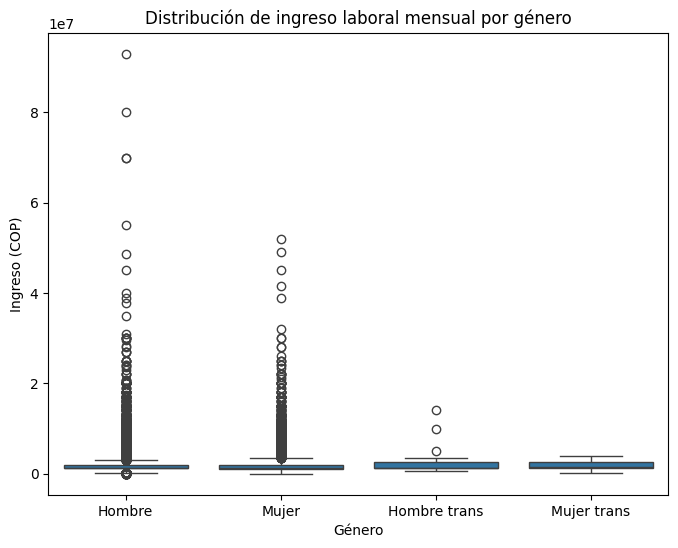

T-statistic: 7.943 — p-value: 2.001e-15
95 % CI diferencia de medias (Hombre – Mujer): [98031.42, 162256.36]


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapea los códigos de GENERO a etiquetas legibles
genero_map = {
    1: "Hombre",
    2: "Mujer",
    3: "Hombre trans",
    4: "Mujer trans",
}
df['GENERO_LABEL'] = df['GENERO'].map(genero_map).astype('category')

# Filtra solo los dos grupos principales para el t-test
ing_hombre = df[df['GENERO_LABEL'] == 'Hombre']['INGRESO'].dropna()
ing_mujer  = df[df['GENERO_LABEL'] == 'Mujer']['INGRESO'].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_genero = df.groupby('GENERO_LABEL')['INGRESO'] \
                 .agg(count='count', mean='mean', median='median', std='std') \
                 .reset_index()
print(stats_genero)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(8, 6))
sns.boxplot(x='GENERO_LABEL', y='INGRESO', data=df)
plt.title('Distribución de ingreso laboral mensual por género')
plt.xlabel('Género')
plt.ylabel('Ingreso (COP)')
plt.show()

# ——————————————
# 4. Prueba estadística (t-test de Welch)
# ——————————————
tstat, pval = stats.ttest_ind(ing_hombre, ing_mujer, equal_var=False)
print(f"T-statistic: {tstat:.3f} — p-value: {pval:.3e}")

# ——————————————
# 5. Intervalo de confianza de la diferencia de medias
# ——————————————
cm = CompareMeans(DescrStatsW(ing_hombre), DescrStatsW(ing_mujer))
ci_low, ci_upp = cm.tconfint_diff(usevar='unequal')
print(f"95 % CI diferencia de medias (Hombre – Mujer): [{ci_low:.2f}, {ci_upp:.2f}]")

#### Disparidades étnicas

        ETNIA_LABEL  count          mean     median           std
0          Indígena   1584  1.449678e+06  1300000.0  1.314374e+06
1      Gitano (Rom)      6  1.321667e+06  1400000.0  7.629002e+05
2            Raizal    168  2.068292e+06  1500000.0  1.563500e+06
3        Palenquero     10  1.386500e+06  1300000.0  9.799321e+05
4  Afrodescendiente   4212  1.628553e+06  1300000.0  1.361922e+06
5           Ninguno  54001  1.925563e+06  1300000.0  2.078836e+06


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\521665977.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('ETNIA_LABEL')['INGRESO']


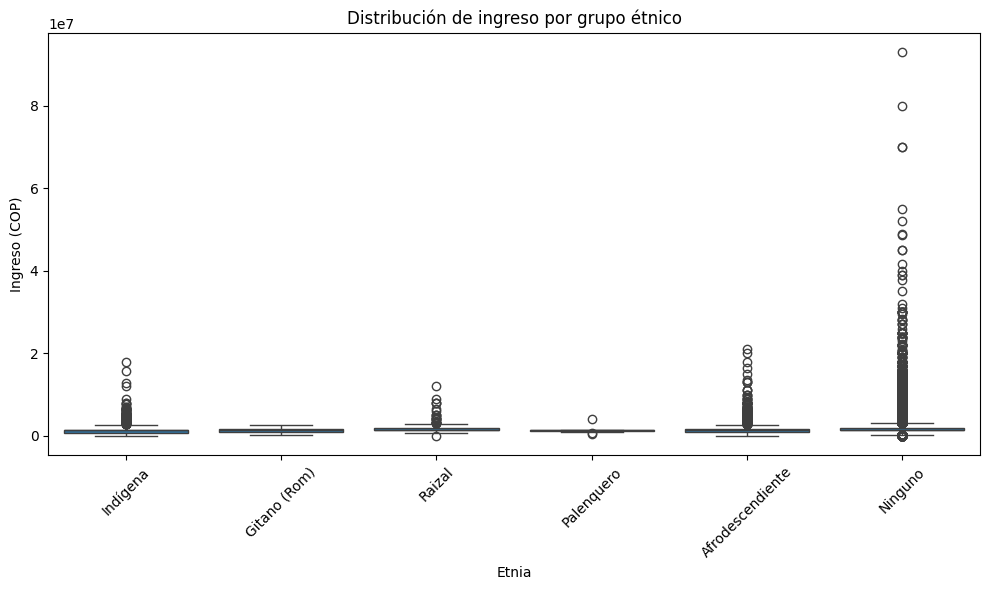

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\521665977.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, grupo in df_etnia.groupby('ETNIA_LABEL')


ANOVA F-statistic: 33.030 — p-value: 8.822e-34
Kruskal-Wallis H-statistic: 399.410 — p-value: 3.975e-84
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
     group1         group2      meandiff   p-adj      lower        upper     reject
-----------------------------------------------------------------------------------
Afrodescendiente Gitano (Rom) -306885.9395 0.9991 -2656790.3611 2043018.4822  False
Afrodescendiente     Indígena -178874.9881 0.0316  -348409.8964   -9340.0798   True
Afrodescendiente      Ninguno  297010.2343    0.0   204990.3622  389030.1064   True
Afrodescendiente   Palenquero -242052.6061  0.999 -2063143.6161 1579038.4038  False
Afrodescendiente       Raizal  439739.0605 0.0625   -12798.8323  892276.9534  False
    Gitano (Rom)     Indígena  128010.9514    1.0 -2224664.7416 2480686.6444  False
    Gitano (Rom)      Ninguno  603896.1738 0.9779 -1744466.7642 2952259.1117  False
    Gitano (Rom)   Palenquero   64833.3333    1.0   -290

In [15]:
# 2.2 Disparidades étnicas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ——————————————
# 1. Preparar los datos
# ——————————————
etnia_map = {
    1: "Indígena",
    2: "Gitano (Rom)",
    3: "Raizal",
    4: "Palenquero",
    5: "Afrodescendiente",
    6: "Ninguno"
}
# Crear etiqueta legible
df['ETNIA_LABEL'] = df['ETNIA'].map(etnia_map).astype('category')
# Subconjunto limpio
df_etnia = df[['ETNIA_LABEL', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_etnia = (
    df_etnia
    .groupby('ETNIA_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print(stats_etnia)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(10, 6))
sns.boxplot(x='ETNIA_LABEL', y='INGRESO', data=df_etnia)
plt.xticks(rotation=45)
plt.title('Distribución de ingreso por grupo étnico')
plt.xlabel('Etnia')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Prueba estadística (ANOVA de un factor)
# ——————————————
# Prepara una lista con los arrays de ingreso por cada grupo
grupos = [
    grupo['INGRESO'].values
    for _, grupo in df_etnia.groupby('ETNIA_LABEL')
]
f_stat, p_val = f_oneway(*grupos)
print(f"ANOVA F-statistic: {f_stat:.3f} — p-value: {p_val:.3e}")

# Si prefieres un test no paramétrico en caso de violar supuestos:
h_stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis H-statistic: {h_stat:.3f} — p-value: {p_kw:.3e}")

# ——————————————
# 5. Post-hoc (Tukey HSD)
# ——————————————
tukey = pairwise_tukeyhsd(endog=df_etnia['INGRESO'],
                          groups=df_etnia['ETNIA_LABEL'],
                          alpha=0.05)
print(tukey.summary())


#### Diferencias regionales

            DPTO_LABEL  count          mean     median           std
0            Antioquia   4845  2.109020e+06  1400000.0  2.252064e+06
1            Atlántico   2565  1.861602e+06  1300000.0  1.819132e+06
2          Bogotá D.C.   2885  2.667090e+06  1500000.0  3.897411e+06
3              Bolívar   1857  1.840205e+06  1300000.0  1.729388e+06
4               Boyacá   2256  2.020568e+06  1300000.0  1.975072e+06
5               Caldas   3703  1.965702e+06  1300000.0  2.604170e+06
6              Caquetá   1781  1.780827e+06  1300000.0  1.473107e+06
7                Cauca   1828  1.784331e+06  1300000.0  1.657348e+06
8                Cesar   1636  1.556403e+06  1300000.0  1.314707e+06
9                Chocó   1285  1.657061e+06  1300000.0  1.249269e+06
10        Cundinamarca   1546  1.719283e+06  1300000.0  1.692921e+06
11             Córdoba   1910  1.729590e+06  1300000.0  2.389103e+06
12               Huila   1822  1.979307e+06  1400000.0  1.823938e+06
13          La Guajira   1245  1.7

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\803501879.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('DPTO_LABEL')['INGRESO']


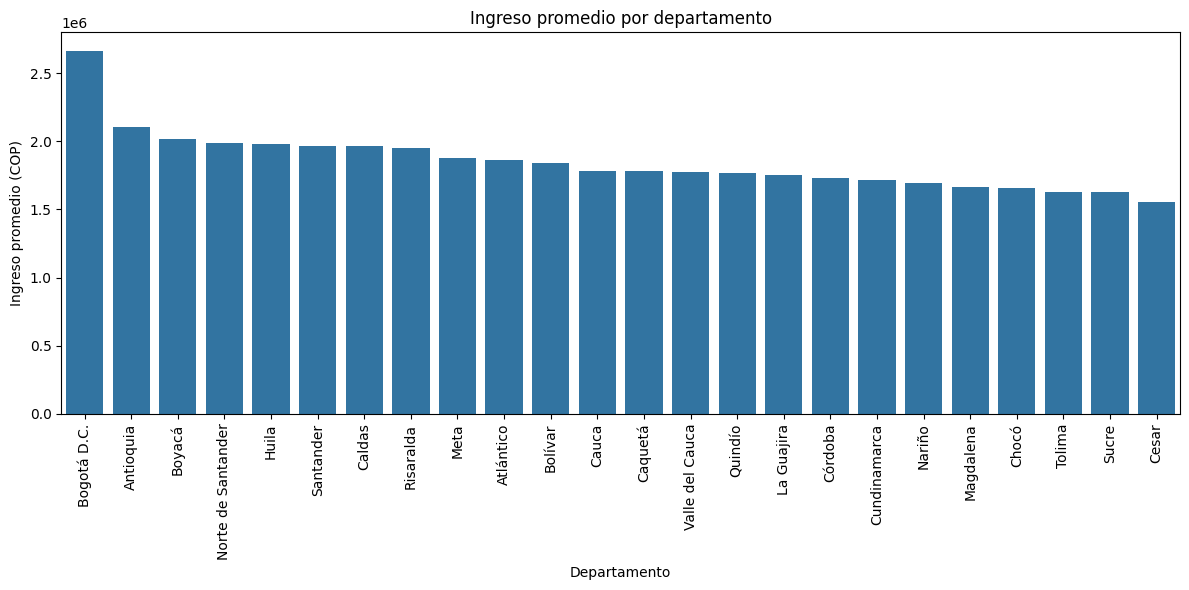

ANOVA F-statistic: 32.576 — p-value: 1.819e-142
Kruskal-Wallis H-statistic: 1736.283 — p-value: 0.000e+00


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\803501879.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [grp['INGRESO'].values for _, grp in df_reg.groupby('DPTO_LABEL')]


In [16]:
# 2.3 Diferencias regionales

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal

# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapear códigos de departamento a nombres legibles
dpto_map = {
    5: "Antioquia", 8: "Atlántico", 11: "Bogotá D.C.", 13: "Bolívar", 15: "Boyacá", 17: "Caldas",
    18: "Caquetá", 19: "Cauca", 20: "Cesar", 23: "Córdoba", 25: "Cundinamarca", 27: "Chocó",
    41: "Huila", 44: "La Guajira", 47: "Magdalena", 50: "Meta", 52: "Nariño", 54: "Norte de Santander",
    63: "Quindío", 66: "Risaralda", 68: "Santander", 70: "Sucre", 73: "Tolima", 76: "Valle del Cauca"
}
df['DPTO_LABEL'] = df['DPTO'].map(dpto_map).astype('category')

# Crear subset limpio
df_reg = df[['DPTO_LABEL', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_reg = (
    df_reg
    .groupby('DPTO_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print(stats_reg)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(12, 6))
order = stats_reg.sort_values('mean', ascending=False)['DPTO_LABEL']
sns.barplot(x='DPTO_LABEL', y='mean', data=stats_reg, order=order)
plt.xticks(rotation=90)
plt.title('Ingreso promedio por departamento')
plt.xlabel('Departamento')
plt.ylabel('Ingreso promedio (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Pruebas estadísticas
# ——————————————
# Preparar lista de arrays de ingreso por departamento
grupos = [grp['INGRESO'].values for _, grp in df_reg.groupby('DPTO_LABEL')]

# ANOVA de un factor
f_stat, p_anova = f_oneway(*grupos)
print(f"ANOVA F-statistic: {f_stat:.3f} — p-value: {p_anova:.3e}")

# Kruskal-Wallis como respaldo no paramétrico
h_stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis H-statistic: {h_stat:.3f} — p-value: {p_kw:.3e}")


#### Impacto educativo

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\4148724901.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('EDUC_LABEL')['INGRESO']


                                EDUC_LABEL  count          mean     median  \
0                                  Ninguno    819  8.185714e+05   800000.0   
1                               Preescolar      3  9.166667e+05  1000000.0   
2                  Básica primaria (1°-5°)   6992  1.044347e+06  1200000.0   
3                Básica secundaria (6°-9°)   4755  1.107564e+06  1300000.0   
4   Media académica (Bachillerato clásico)  19743  1.331674e+06  1300000.0   
5     Media técnica (Bachillerato técnico)   1746  1.408576e+06  1300000.0   
6                               Normalista    138  2.005435e+06  1800000.0   
7                      Técnica profesional   6546  1.600441e+06  1300000.0   
8                              Tecnológica   3369  1.874198e+06  1500000.0   
9                            Universitaria  11339  2.676438e+06  2050000.0   
10                         Especialización   2845  5.051428e+06  4100000.0   
11                                Maestría   1467  5.568133e+06 

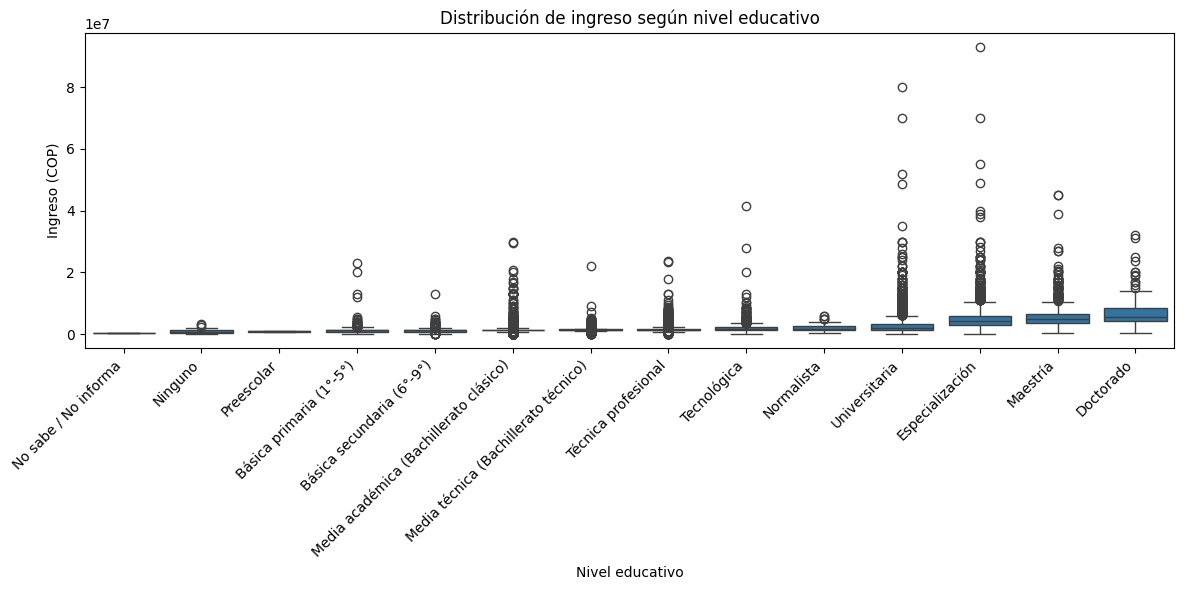

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\4148724901.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [grp['INGRESO'].values for _, grp in df_ed.groupby('EDUC_LABEL')]


ANOVA F-statistic: 2126.245 — p-value: 0.000e+00
Kruskal-Wallis H-statistic: 22748.584 — p-value: 0.000e+00
                                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                group1                                 group2                    meandiff   p-adj      lower          upper     reject
--------------------------------------------------------------------------------------------------------------------------------------
               Básica primaria (1°-5°)              Básica secundaria (6°-9°)    63216.9467 0.7611    -42205.1652   168639.0585  False
               Básica primaria (1°-5°)                              Doctorado  6108948.6152    0.0    5723219.098  6494678.1324   True
               Básica primaria (1°-5°)                        Especialización  4007080.5489    0.0   3882361.2421  4131799.8557   True
               Básica primaria (1°-5°)                               Maestría  452

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapeo completo según tu diccionario P3042 → niveles educativos
ed_map = {
    1: "Ninguno",
    2: "Preescolar",
    3: "Básica primaria (1°-5°)",
    4: "Básica secundaria (6°-9°)",
    5: "Media académica (Bachillerato clásico)",
    6: "Media técnica (Bachillerato técnico)",
    7: "Normalista",
    8: "Técnica profesional",
    9: "Tecnológica",
    10: "Universitaria",
    11: "Especialización",
    12: "Maestría",
    13: "Doctorado",
    99: "No sabe / No informa"
}
df['EDUC_LABEL'] = df['MAXIMO_NIVEL_EDUCATIVO'].map(ed_map).astype('category')

# Subconjunto limpio
df_ed = df[['EDUC_LABEL', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_ed = (
    df_ed
    .groupby('EDUC_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print(stats_ed)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(12, 6))
order = stats_ed.sort_values('mean', ascending=True)['EDUC_LABEL']
sns.boxplot(x='EDUC_LABEL', y='INGRESO', data=df_ed, order=order)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de ingreso según nivel educativo')
plt.xlabel('Nivel educativo')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Pruebas estadísticas
# ——————————————
grupos = [grp['INGRESO'].values for _, grp in df_ed.groupby('EDUC_LABEL')]

# ANOVA de un factor
f_stat, p_anova = f_oneway(*grupos)
print(f"ANOVA F-statistic: {f_stat:.3f} — p-value: {p_anova:.3e}")

# Kruskal-Wallis como alternativa no paramétrica
h_stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis H-statistic: {h_stat:.3f} — p-value: {p_kw:.3e}")

# ——————————————
# 5. Post-hoc (Tukey HSD)
# ——————————————
tukey = pairwise_tukeyhsd(endog=df_ed['INGRESO'],
                          groups=df_ed['EDUC_LABEL'],
                          alpha=0.05)
print(tukey.summary())


#### Ocupación y tipo de contrato

In [18]:
# 1. Definir el mapeo de prefijos a grupo
prefijo_map = {
    '0': "Fuerzas militares",
    '1': "Directores y gerentes",
    '2': "Profesionales, científicos e intelectuales",
    '3': "Técnicos y profesionales de nivel medio",
    '4': "Personal de apoyo administrativo",
    '5': "Trabajadores de los servicios y vendedores de comercios y mercados",
    '6': "Agricultores y trabajadores calificados agropecuarios, forestales y pesqueros",
    '7': "Oficiales, operarios, artesanos y oficios relacionados",
    '8': "Operadores de instalaciones y máquinas y ensambladores",
    '9': "Ocupaciones elementales"
}

# 2. Asegurarse de que OCUPACION sea cadena para poder extraer el primer carácter
df['OCUP_STR'] = df['OCUPACION'].astype(str)

# 3. Mapear según el primer dígito
df['GRUPO_OCUPACION'] = df['OCUP_STR'].str[0].map(prefijo_map).astype('category')

# 4. (Opcional) Limpiar columna auxiliar
df.drop(columns=['OCUP_STR'], inplace=True)

# 5. Verifica el resultado
print(df[['OCUPACION', 'GRUPO_OCUPACION']].drop_duplicates().head(15))


    OCUPACION                                    GRUPO_OCUPACION
2        3121            Técnicos y profesionales de nivel medio
3        9311                            Ocupaciones elementales
4        6210  Agricultores y trabajadores calificados agrope...
5        5322  Trabajadores de los servicios y vendedores de ...
9        8111  Operadores de instalaciones y máquinas y ensam...
19       5131  Trabajadores de los servicios y vendedores de ...
21       6121  Agricultores y trabajadores calificados agrope...
24       9313                            Ocupaciones elementales
38       5311  Trabajadores de los servicios y vendedores de ...
39       8343  Operadores de instalaciones y máquinas y ensam...
41       1212                              Directores y gerentes
42       2330         Profesionales, científicos e intelectuales
43       3423            Técnicos y profesionales de nivel medio
44       9510                            Ocupaciones elementales
45       7212  Oficiales,

Descriptivos por grupo de ocupación:
                                     GRUPO_OCUPACION  count          mean  \
0  Agricultores y trabajadores calificados agrope...    835  1.130662e+06   
1                              Directores y gerentes   3617  3.408364e+06   
2                                  Fuerzas militares      3  1.766667e+06   
3                            Ocupaciones elementales  13078  1.039193e+06   
4  Oficiales, operarios, artesanos y oficios rela...   4688  1.435478e+06   
5  Operadores de instalaciones y máquinas y ensam...   3790  1.491715e+06   
6                   Personal de apoyo administrativo   6181  1.752548e+06   
7         Profesionales, científicos e intelectuales   8282  3.890593e+06   
8  Trabajadores de los servicios y vendedores de ...  15081  1.362088e+06   
9            Técnicos y profesionales de nivel medio   4426  2.408533e+06   

      median           std  
0  1300000.0  7.140274e+05  
1  2400000.0  3.709839e+06  
2  1800000.0  2.516611e+05  

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\1006883540.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('GRUPO_OCUPACION')['INGRESO']
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\1006883540.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('CONTRATO_LABEL')['INGRESO']


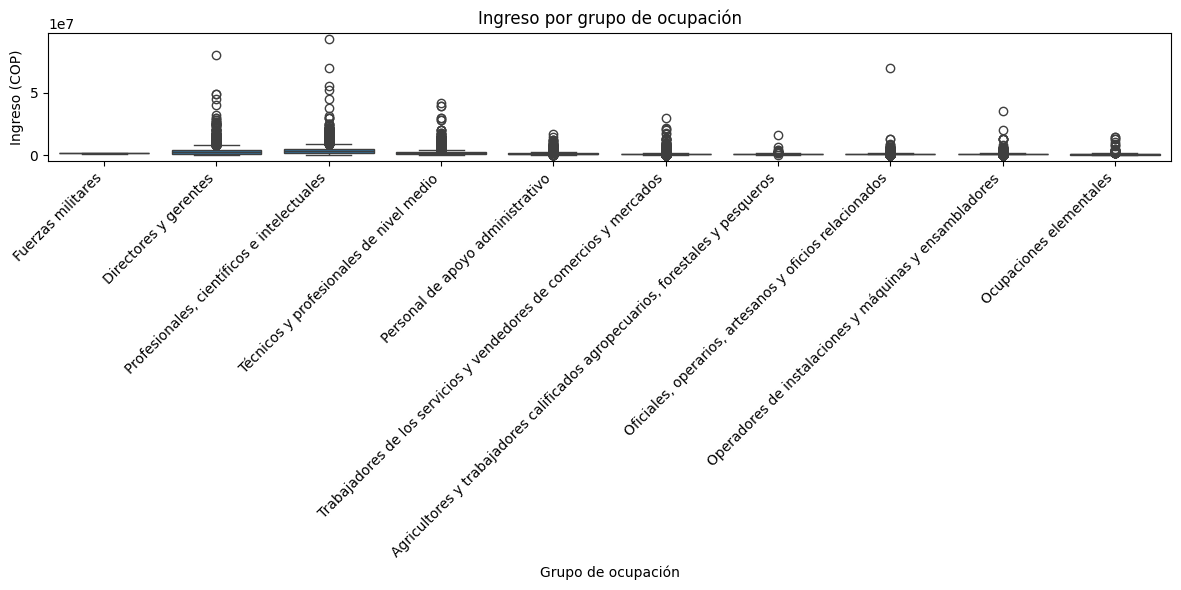

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2180\1006883540.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos_ocup = [grp['INGRESO'].values for _, grp in df_ocup.groupby('GRUPO_OCUPACION') if len(grp) >= 30]
c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)



ANOVA grupo de ocupación: F=2352.034, p=0.000e+00
T-test contrato (Verbal vs. Escrito): t=nan, p=nan

Tukey HSD grupo de ocupación:
                                                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                                           
                                    group1                                                                  group2                                  meandiff   p-adj      lower         upper     reject
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Agricultores y trabajadores calificados agropecuarios, forestales y pesqueros                                              Directores y gerentes  2277701.8555    0.0  2063499.2534  2491904.4576   True
Agricultores y trabajadores calificados agropecuarios, forestal

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapeo de prefijos (primer dígito) a grupo principal
prefijo_map = {
    '0': "Fuerzas militares",
    '1': "Directores y gerentes",
    '2': "Profesionales, científicos e intelectuales",
    '3': "Técnicos y profesionales de nivel medio",
    '4': "Personal de apoyo administrativo",
    '5': "Trabajadores de los servicios y vendedores de comercios y mercados",
    '6': "Agricultores y trabajadores calificados agropecuarios, forestales y pesqueros",
    '7': "Oficiales, operarios, artesanos y oficios relacionados",
    '8': "Operadores de instalaciones y máquinas y ensambladores",
    '9': "Ocupaciones elementales"
}

# Creamos la columna GRUPO_OCUPACION a partir del primer dígito de OCUPACION
df['GRUPO_OCUPACION'] = (
    df['OCUPACION']
      .astype(str)
      .str[0]
      .map(prefijo_map)
      .astype('category')
)

# Contrato (igual que antes)
contract_map = {
    1: "Sin contrato",
    2: "Verbal",
    3: "Escrito"
}
df['CONTRATO_LABEL'] = df['EXISTENCIA_CONTRATO'].map(contract_map).astype('category')

# Subsets limpios
df_ocup     = df[['GRUPO_OCUPACION', 'INGRESO']].dropna()
df_contract = df[['CONTRATO_LABEL',  'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_ocup = (
    df_ocup
    .groupby('GRUPO_OCUPACION')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print("Descriptivos por grupo de ocupación:")
print(stats_ocup)

stats_contract = (
    df_contract
    .groupby('CONTRATO_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print("\nDescriptivos por tipo de contrato:")
print(stats_contract)

# ——————————————
# 3. Visualizaciones
# ——————————————
# Boxplot por grupo de ocupación (son solo 10 categorías)
plt.figure(figsize=(12, 6))
sns.boxplot(x='GRUPO_OCUPACION', y='INGRESO', data=df_ocup,
            order=prefijo_map.values())
plt.xticks(rotation=45, ha='right')
plt.title('Ingreso por grupo de ocupación')
plt.xlabel('Grupo de ocupación')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Pruebas estadísticas
# ——————————————
# ANOVA para grupo de ocupación
grupos_ocup = [grp['INGRESO'].values for _, grp in df_ocup.groupby('GRUPO_OCUPACION') if len(grp) >= 30]
f_stat, p_ocup = f_oneway(*grupos_ocup)
print(f"\nANOVA grupo de ocupación: F={f_stat:.3f}, p={p_ocup:.3e}")

# T-test entre “Verbal” y “Escrito” para contrato
ing_verbal  = df_contract[df_contract['CONTRATO_LABEL']=='Verbal']['INGRESO']
ing_escrito = df_contract[df_contract['CONTRATO_LABEL']=='Escrito']['INGRESO']
tstat, p_cont = ttest_ind(ing_verbal, ing_escrito, equal_var=False)
print(f"T-test contrato (Verbal vs. Escrito): t={tstat:.3f}, p={p_cont:.3e}")

# Post-hoc Tukey para grupo de ocupación
tukey = pairwise_tukeyhsd(endog=df_ocup['INGRESO'],
                          groups=df_ocup['GRUPO_OCUPACION'],
                          alpha=0.05)
print("\nTukey HSD grupo de ocupación:")
print(tukey.summary())


#### Horas de trabajo doméstico y cuidado

Limpieza doméstica:
count    35819.000000
mean         1.755130
std          0.931654
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: LIMPIEZA_EN_SU_HOGAR_HORAS_DIA, dtype: float64 

Cuidado de niños:
count    5563.000000
mean        5.253101
std         4.736525
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        24.000000
Name: CUIDADO_NINOS_SU_HOGAR_HORAS_DIA, dtype: float64 



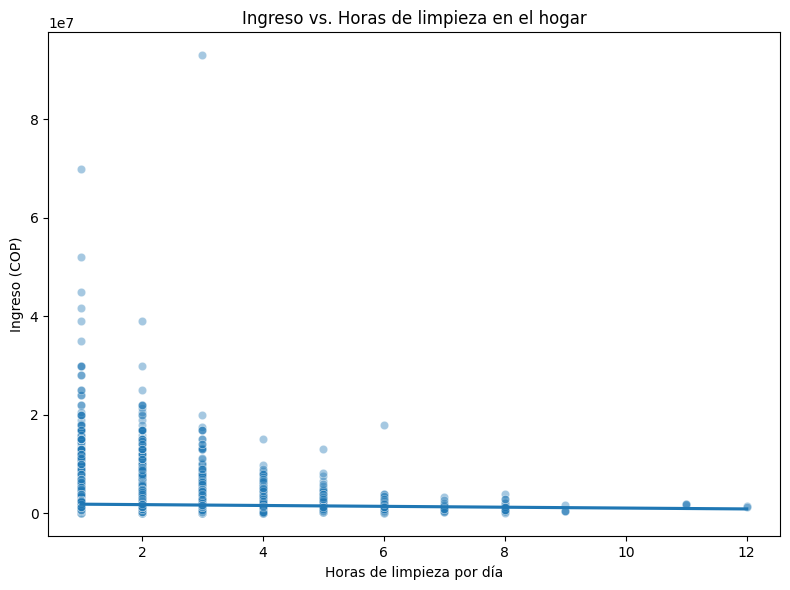

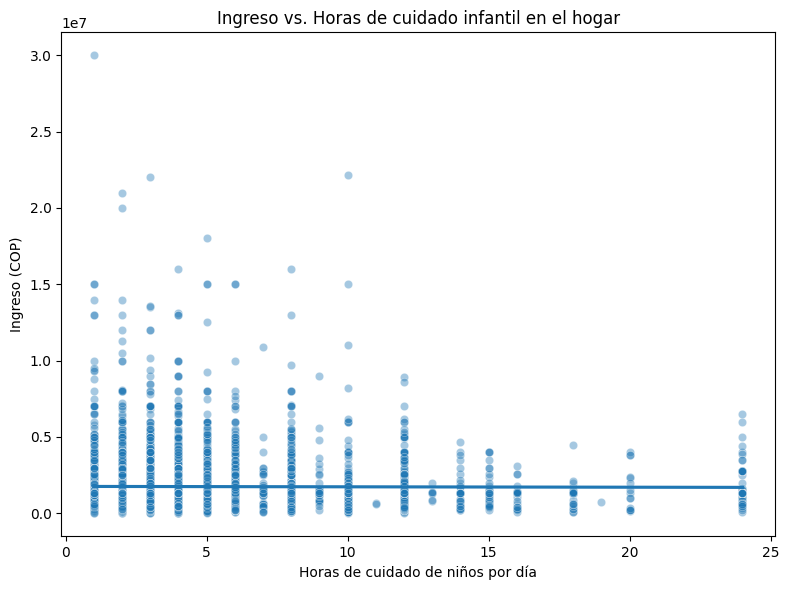

Limpieza doméstica – Pearson r: -0.045, p = 3.411e-17
Limpieza doméstica – Spearman ρ: -0.052, p = 2.744e-23

Cuidado de niños – Pearson r: -0.007, p = 5.802e-01
Cuidado de niños – Spearman ρ: -0.001, p = 9.661e-01


In [20]:
# 2.6 Horas de trabajo doméstico y cuidado

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ——————————————
# 1. Preparar los datos
# ——————————————
# Limpieza doméstica
df_dom = df[['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', 'INGRESO']].dropna()

# Cuidado de niños
df_cuid = df[['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
print("Limpieza doméstica:")
print(df_dom['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA'].describe(), "\n")

print("Cuidado de niños:")
print(df_cuid['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'].describe(), "\n")

# ——————————————
# 3. Visualizaciones (scatter + línea de tendencia)
# ——————————————
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', y='INGRESO', data=df_dom, alpha=0.4)
sns.regplot(x='LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', y='INGRESO', data=df_dom,
            scatter=False, ci=None)
plt.title('Ingreso vs. Horas de limpieza en el hogar')
plt.xlabel('Horas de limpieza por día')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='CUIDADO_NINOS_SU_HOGAR_HORAS_DIA', y='INGRESO', data=df_cuid, alpha=0.4)
sns.regplot(x='CUIDADO_NINOS_SU_HOGAR_HORAS_DIA', y='INGRESO', data=df_cuid,
            scatter=False, ci=None)
plt.title('Ingreso vs. Horas de cuidado infantil en el hogar')
plt.xlabel('Horas de cuidado de niños por día')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Correlaciones
# ——————————————
pear_dom, p_dom = pearsonr(df_dom['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA'], df_dom['INGRESO'])
spe_dom, sp_dom = spearmanr(df_dom['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA'], df_dom['INGRESO'])
print(f"Limpieza doméstica – Pearson r: {pear_dom:.3f}, p = {p_dom:.3e}")
print(f"Limpieza doméstica – Spearman ρ: {spe_dom:.3f}, p = {sp_dom:.3e}\n")

pear_cuid, p_cuid = pearsonr(df_cuid['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'], df_cuid['INGRESO'])
spe_cuid, sp_cuid = spearmanr(df_cuid['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'], df_cuid['INGRESO'])
print(f"Cuidado de niños – Pearson r: {pear_cuid:.3f}, p = {p_cuid:.3e}")
print(f"Cuidado de niños – Spearman ρ: {spe_cuid:.3f}, p = {sp_cuid:.3e}")



#### Asociación entre género y existencia de contrato

#### Historia de vida

In [21]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# 1) Definir features y target
features = [
    'GENERO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EDAD', 'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
target = 'INGRESO'

df_ridge = df[features + [target]].dropna()
X = df_ridge[features]
y = df_ridge[target]

# 2) Preprocesamiento: one-hot para categóricas
categorical_cols = ['GENERO', 'ETNIA', 'DPTO', 'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION']

# Usa sparse_output=False en lugar de sparse=False

preprocessor = ColumnTransformer([
    ("ohe",
     OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
     ['GENERO', 'ETNIA', 'DPTO', 'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION']),
], remainder='passthrough')


# 3) Pipeline con RidgeCV
alphas = np.logspace(-2, 6, 50)
model = make_pipeline(
    preprocessor,
    RidgeCV(alphas=alphas, cv=5, scoring='r2')
)

# Validación cruzada R²
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² CV promedio:", cv_scores.mean().round(3))

# Entrenar en todo el set
model.fit(X, y)
print("Alpha seleccionado:", model.named_steps['ridgecv'].alpha_)

# 4) Definir perfiles y convertir horas semanales → diarias
mean_horas_trabajo = df['HORAS_TRABAJO'].mean()
servicios = 5  # código ocupación servicios y ventas

perfiles = [
    {
        'nombre': 'Mujer nativa Caribe 17a',
        'GENERO': 2, 'ETNIA': 1, 'DPTO': 8,
        'MAXIMO_NIVEL_EDUCATIVO': 5, 'OCUPACION': servicios,
        'EDAD': 17, 'HORAS_TRABAJO': mean_horas_trabajo,
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 10/7,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 5/7,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 5/7
    },
    {
        'nombre': 'Hombre 17a Bogotá adinerado',
        'GENERO': 1, 'ETNIA': 6, 'DPTO': 11,
        'MAXIMO_NIVEL_EDUCATIVO': 5, 'OCUPACION': servicios,
        'EDAD': 17, 'HORAS_TRABAJO': mean_horas_trabajo,
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 0
    },
    {
        'nombre': 'Mujer 17a Bogotá sin uni',
        'GENERO': 2, 'ETNIA': 6, 'DPTO': 11,
        'MAXIMO_NIVEL_EDUCATIVO': 3, 'OCUPACION': servicios,
        'EDAD': 17, 'HORAS_TRABAJO': mean_horas_trabajo,
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 0
    }
]

perf = pd.DataFrame(perfiles)

# 5) Predecir ingresos
perf['PRED_INGRESO'] = model.predict(perf[features])
print(perf[['nombre', 'PRED_INGRESO']])


c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ASUS\anaconda3\en

R² CV promedio: -0.425
Alpha seleccionado: 1.325711365590108
                        nombre  PRED_INGRESO
0      Mujer nativa Caribe 17a  1.146401e+06
1  Hombre 17a Bogotá adinerado  2.489953e+06
2     Mujer 17a Bogotá sin uni  1.667414e+06


c:\Users\ASUS\anaconda3\envs\analitica\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### A personal example

In [22]:
import pandas as pd
import statsmodels.formula.api as smf

# —————————————————————————————————————————————
# 1) Ajustar el modelo OLS simplificado (sin DPTO ni OCUPACIÓN)
# —————————————————————————————————————————————
# Seleccionar variables y limpiar nulos
cols_simple = [
    'INGRESO',
    'GENERO',
    'ETNIA',
    'MAXIMO_NIVEL_EDUCATIVO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
df_simple = df[cols_simple].dropna()

# Definir y ajustar la fórmula
formula_simple = (
    'INGRESO ~ C(GENERO) + C(ETNIA) + C(MAXIMO_NIVEL_EDUCATIVO) + '
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA + '
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA + '
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
)
model_simple = smf.ols(formula_simple, data=df_simple).fit()

# Mostrar resumen breve
print(model_simple.summary().tables[1])

# —————————————————————————————————————————————
# 2) Extraer coeficientes e intervalos de confianza
# —————————————————————————————————————————————
params = model_simple.params
conf   = model_simple.conf_int(alpha=0.05)

beta_gender = params['C(GENERO)[T.2.0]']
ci_gender   = conf.loc['C(GENERO)[T.2.0]'].tolist()

beta_clean  = params['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA']
ci_clean    = conf.loc['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA'].tolist()

beta_child  = params['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA']
ci_child    = conf.loc['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'].tolist()

beta_elder  = params['CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA']
ci_elder    = conf.loc['CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'].tolist()

print(f"\nPérdida por ser mujer (vs. hombre): {beta_gender:,.0f} COP "
      f"(IC 95% [{ci_gender[0]:,.0f}, {ci_gender[1]:,.0f}])")
print(f"Efecto por hora extra de limpieza: {beta_clean:,.0f} COP "
      f"(IC 95% [{ci_clean[0]:,.0f}, {ci_clean[1]:,.0f}])")
print(f"Efecto por hora extra de cuidado de niños: {beta_child:,.0f} COP "
      f"(IC 95% [{ci_child[0]:,.0f}, {ci_child[1]:,.0f}])")
print(f"Efecto por hora extra de cuidado de mayores: {beta_elder:,.0f} COP "
      f"(IC 95% [{ci_elder[0]:,.0f}, {ci_elder[1]:,.0f}])")

# —————————————————————————————————————————————
# 3) Definir un perfil sintético (Luisa García)
# —————————————————————————————————————————————
perfil = {
    'nombre': 'Luisa García',
    'GENERO': 2,   # Mujer
    'ETNIA': 6,    # Ninguno (blanca/mestiza)
    'MAXIMO_NIVEL_EDUCATIVO': 9,  # Tecnológica
    # Horas diarias calculadas a partir de semanales:
    # 14 h limpieza semanal → 2 h/día, 7 h niños → 1 h/día, 3.5 h mayores → 0.5 h/día
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 14 / 7,
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 7 / 7,
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 3.5 / 7
}
perfil_df = pd.DataFrame([perfil])

# —————————————————————————————————————————————
# 4) Calcular pérdidas individuales y total
# —————————————————————————————————————————————
hig = perfil['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA']
hch = perfil['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA']
hme = perfil['CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA']

delta_gender = beta_gender
delta_clean  = hig * beta_clean
delta_child  = hch * beta_child
delta_elder  = hme * beta_elder
delta_total  = delta_gender + delta_clean + delta_child + delta_elder

print(f"\n--- Pérdidas estimadas para {perfil['nombre']} ---")
print(f"Pérdida por género:           {delta_gender:,.0f} COP")
print(f"Pérdida por limpieza (2 h/d): {delta_clean:,.0f} COP")
print(f"Pérdida por cuidado niños (1 h/d): {delta_child:,.0f} COP")
print(f"Pérdida por cuidado mayores (0.5 h/d): {delta_elder:,.0f} COP")
print(f"Pérdida total estimada:       {delta_total:,.0f} COP")


                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           1.186e+06   1.28e+06      0.923      0.360   -1.39e+06    3.76e+06
C(GENERO)[T.2.0]                   -1.116e+06   3.14e+05     -3.550      0.001   -1.75e+06   -4.85e+05
C(GENERO)[T.3.0]                    3.688e-10   7.34e-10      0.502      0.618   -1.11e-09    1.84e-09
C(GENERO)[T.4.0]                   -1.771e-09   1.82e-09     -0.973      0.335   -5.42e-09    1.88e-09
C(ETNIA)[T.2]                      -2.535e-10   1.04e-09     -0.243      0.809   -2.34e-09    1.84e-09
C(ETNIA)[T.3]                      -3.394e-10   1.96e-09     -0.173      0.863   -4.27e-09     3.6e-09
C(ETNIA)[T.4]                      -1.046e-09   7.84e-10     -1.335      0.188   -2.62e-09    5.27e-10
C(ETNIA)[T.5]                       1.021e+06   7.62e+05      1.339      

#### A small step in the right direction

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 1) Filtrar y limpiar datos para Bogotá D.C. (DPTO == 11)
df_city = df[df['DPTO'] == 11].dropna(subset=[
    'INGRESO',
    'GENERO',
    'ETNIA',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
])

# 2) Estandarizar las variables numéricas
num_cols = [
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
scaler = StandardScaler()
df_city[num_cols] = scaler.fit_transform(df_city[num_cols])

# 3) Crear dummies de las variables categóricas
cat_cols = ['GENERO', 'ETNIA', 'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION']
df_dummies = pd.get_dummies(df_city[cat_cols], drop_first=True)

# 4) Preparar matriz de diseño X e y
X = pd.concat([df_dummies, df_city[num_cols]], axis=1)
X = sm.add_constant(X)                # agrega el intercepto
X = X.astype(float)                   # convertimos TODO a float
y = df_city['INGRESO']

# 5) Ajustar OLS
model = sm.OLS(y, X).fit()

# 6) Extraer coeficientes estandarizados (magnitud)
beta_abs = model.params.drop('const').abs().sort_values(ascending=False)
top_feature = beta_abs.index[0]
top_beta    = model.params[top_feature]

print(f"El factor más importante en Bogotá D.C. según coeficiente estandarizado es “{top_feature}” con β = {top_beta:.2f}.\n")

print("Top 5 variables por magnitud de coeficiente:")
print(beta_abs.head(5).to_frame(name='|β|'))


El factor más importante en Bogotá D.C. según coeficiente estandarizado es “LIMPIEZA_EN_SU_HOGAR_HORAS_DIA” con β = -891445.89.

Top 5 variables por magnitud de coeficiente:
                                          |β|
LIMPIEZA_EN_SU_HOGAR_HORAS_DIA  891445.885345
ETNIA_6                         740662.143729
MAXIMO_NIVEL_EDUCATIVO_11.0     624006.293906
EDAD                            484930.230566
MAXIMO_NIVEL_EDUCATIVO_10.0     311349.913878


#### A household affair

In [24]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 1) Filtrar madres cabeza de hogar en Meta
df_meta = df[
    (df['DPTO'] == 50) &
    (df['GENERO'] == 2) &
    (df['PARENTESCO_CON_JEFE_HOGAR'] == 1)
].copy()
print("Antes de limpiar horas:", len(df_meta))

# 2) Imputar 0 en horas domésticas/cuidado
for col in [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]:
    df_meta[col] = df_meta[col].fillna(0)

# 3) Ahora dropna solo en ingreso, contrato y educación
df_meta = df_meta.dropna(subset=[
    'INGRESO',
    'EXISTENCIA_CONTRATO',
    'MAXIMO_NIVEL_EDUCATIVO'
])
print("Después de limpiar horas:", len(df_meta))

# 4) Estandarizar numéricas
num_cols = [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
scaler = StandardScaler()
df_meta[num_cols] = scaler.fit_transform(df_meta[num_cols])

# 5) Dummies y diseño
df_meta['CONTRATO_ESCRITO'] = (df_meta['EXISTENCIA_CONTRATO'] == 3).astype(int)
edu_dummies = pd.get_dummies(
    df_meta['MAXIMO_NIVEL_EDUCATIVO'],
    prefix='EDU',
    drop_first=True
)

X = pd.concat([df_meta[['CONTRATO_ESCRITO']], edu_dummies, df_meta[num_cols]], axis=1)
X = sm.add_constant(X).astype(float)
y = df_meta['INGRESO']

# 6) Ajustar OLS y extraer palanca principal
model = sm.OLS(y, X).fit()
beta_abs = model.params.drop('const').abs().sort_values(ascending=False)
top_feature = beta_abs.index[0]
top_beta    = model.params[top_feature]

print(f"\nVariable más importante en Meta (madres cabeza): “{top_feature}”")
print(f"Coeficiente estandarizado (β): {top_beta:.0f} COP por σ")
print("\nTop 5 variables por magnitud de |β|:")
print(beta_abs.head(5).to_frame(name='|β|'))


Antes de limpiar horas: 536
Después de limpiar horas: 536

Variable más importante en Meta (madres cabeza): “EDU_13.0”
Coeficiente estandarizado (β): 8965814 COP por σ

Top 5 variables por magnitud de |β|:
                   |β|
EDU_13.0  8.965814e+06
EDU_12.0  5.067977e+06
EDU_11.0  4.403362e+06
EDU_7.0   2.434018e+06
EDU_10.0  1.613855e+06


### **Sección 3:  Procesamiento de Datos**

In [25]:
vars_num = [
    'INGRESO',
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

# 2) Calcula los límites y cuenta outliers
outliers_summary = []
for col in vars_num:
    serie = df[col].dropna()
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (serie < lower) | (serie > upper)
    n_out = mask.sum()
    outliers_summary.append({
        'Variable': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite inferior': lower,
        'Límite superior': upper,
        'Nº outliers': int(n_out)
    })

outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df)

                             Variable         Q1         Q3       IQR  \
0                             INGRESO  1250000.0  2000000.0  750000.0   
1                                EDAD       29.0       49.0      20.0   
2                       HORAS_TRABAJO       44.0       48.0       4.0   
3      LIMPIEZA_EN_SU_HOGAR_HORAS_DIA        1.0        2.0       1.0   
4    CUIDADO_NINOS_SU_HOGAR_HORAS_DIA        2.0        6.0       4.0   
5  CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA        2.0        6.0       4.0   

   Límite inferior  Límite superior  Nº outliers  
0         125000.0        3125000.0         7440  
1             -1.0             79.0           43  
2             38.0             54.0        12311  
3             -0.5              3.5         1709  
4             -4.0             12.0          325  
5             -4.0             12.0           29  


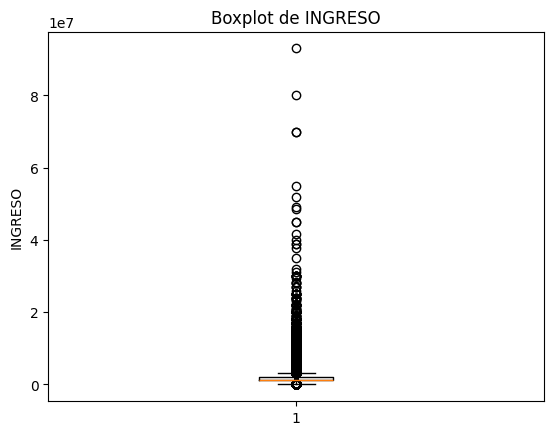

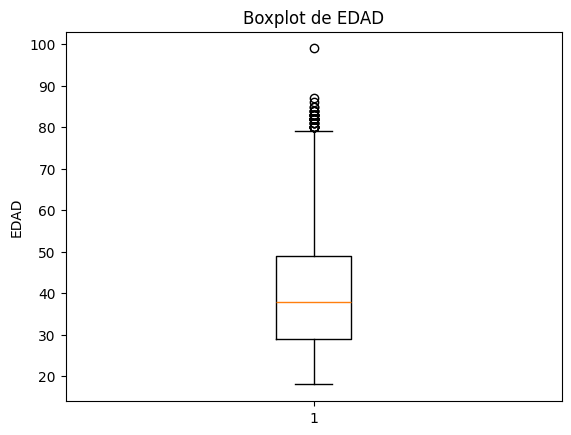

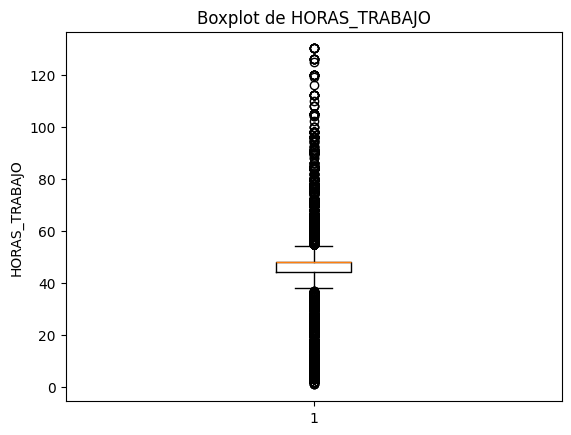

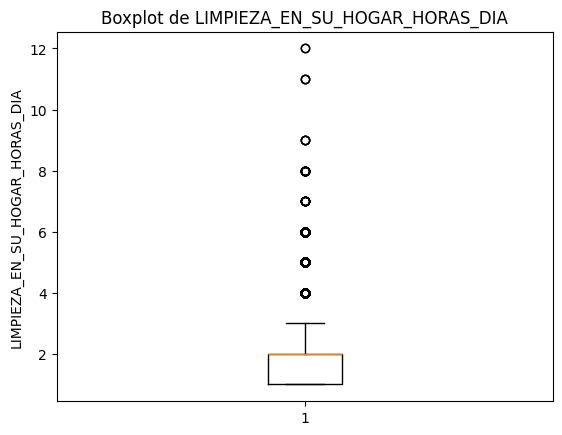

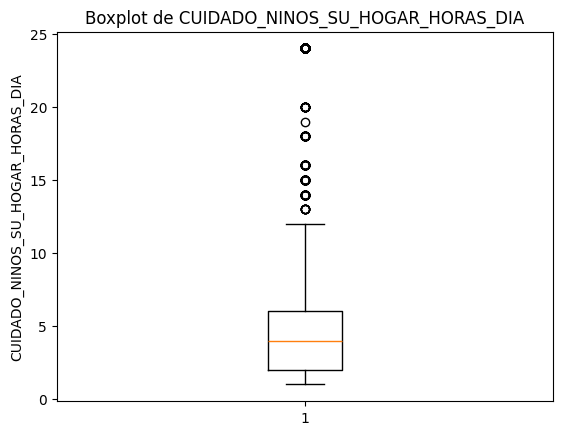

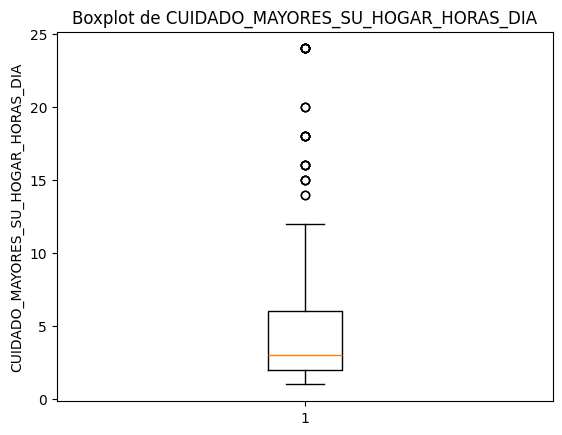

In [26]:
for var in vars_num:
    serie = df[var].dropna()
    plt.figure()
    plt.boxplot(serie)
    plt.title(f"Boxplot de {var}")
    plt.ylabel(var)
    plt.show()

In [27]:
# OUTLIERS DE HORAS(posiblemente negativos)
cols_horas = [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

for col in cols_horas:
    n_neg = (df[col] < 0).sum()
    print(f"{col}: {n_neg} valores negativos")


HORAS_TRABAJO: 0 valores negativos
LIMPIEZA_EN_SU_HOGAR_HORAS_DIA: 0 valores negativos
CUIDADO_NINOS_SU_HOGAR_HORAS_DIA: 0 valores negativos
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA: 0 valores negativos


In [28]:
# OUTLIERS DE EDAD

# Límite superior calculado
limite_sup = df['EDAD'].quantile(0.75) + 1.5 * (df['EDAD'].quantile(0.75) - df['EDAD'].quantile(0.25))
print("Límite superior para outliers en EDAD:", limite_sup)

# Filtrar edades > límite
edades_muy_altas = df[df['EDAD'] > limite_sup]

# Cuántas son y muestras
print(f"Total de casos con EDAD > {limite_sup:.1f} años:", edades_muy_altas.shape[0])
print(edades_muy_altas[['EDAD']].sort_values('EDAD').head(10))


Límite superior para outliers en EDAD: 79.0
Total de casos con EDAD > 79.0 años: 43
       EDAD
10024    80
10961    80
52011    80
78258    80
70879    80
72353    80
50697    80
99994    80
51638    81
1999     81


Resumen de log(INGRESO + 1):
count    59981.000000
mean        14.180179
std          0.786668
min          0.000000
25%         14.038655
50%         14.077876
75%         14.508658
max         18.348110
Name: log_INGRESO, dtype: float64


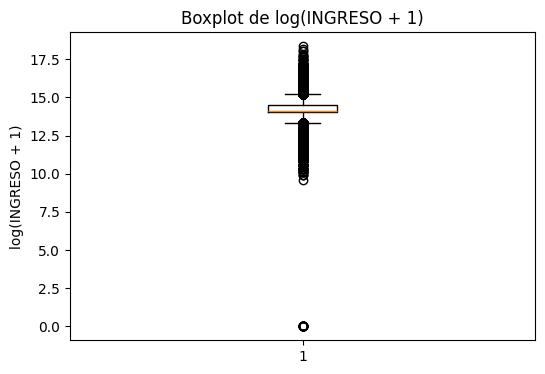

In [29]:
# 1) Transformación logarítmica de INGRESO
df_final['log_INGRESO'] = np.log1p(df_final['INGRESO'])

# 2) Resumen estadístico
print("Resumen de log(INGRESO + 1):")
print(df_final['log_INGRESO'].describe())

# 3) Boxplot para visualizar outliers en escala log
plt.figure(figsize=(6,4))
plt.boxplot(df_final['log_INGRESO'].dropna())
plt.title("Boxplot de log(INGRESO + 1)")
plt.ylabel("log(INGRESO + 1)")
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------
# One Hot Encoding para todas las variables categóricas
# ----------------------------------------------------------
categorical_vars = [
    'GENERO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'URBANO_RURAL',
    'POSICION_OCUPACIONAL',
    'GRUPO_INDIGENA',
    'SECTOR_DETALLADO',
    'SECTOR_AMPLIO',
    'TERMINO_CONTRATO',
    'TIPO_VIVIENDA',
    'TENENCIA_VIVIENDA',
    'CONTRATO_VERBAL_ESCRITO'
]

# Filtrar solo las que existan en df
categorical_vars = [col for col in categorical_vars if col in df.columns]

# Aplicar One Hot Encoding y reemplazar df
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# ----------------------------------------------------------
# Conversión de variables binarias (1="sí", 2="no") a 0/1
# ----------------------------------------------------------
binary_vars = [
    'EXISTENCIA_CONTRATO',
    'ELECTRICIDAD',
    'ACUEDUCTO',
    'GAS_NATURAL',
    'ALCANTARILLADO',
    'AGUA_POTABLE',
    'SABE_LEER',
    'ACTUALMENTE_ESTUDIA'
]

binary_vars = [col for col in binary_vars if col in df.columns]
df[binary_vars] = df[binary_vars].replace({1: 1, 2: 0})

# ----------------------------------------------------------
# Estandarización de variables numéricas
# ----------------------------------------------------------
numeric_vars = [
    'EDAD',
    'HORAS_TRABAJO',
    'TOTAL_PERSONAS_HOGAR',
    'ESTRATO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'
]

numeric_vars = [col for col in numeric_vars if col in df.columns]
scaler = StandardScaler()
df[numeric_vars] = scaler.fit_transform(df[numeric_vars])

# ----------------------------------------------------------
# Verificación final
# ----------------------------------------------------------
print(f"Shape after encoding & scaling: {df.shape}")
print("Example dummy columns:", [c for c in df.columns if 'GENERO_' in c][:5])


Shape after encoding & scaling: (59981, 780)
Example dummy columns: ['GENERO_LABEL', 'GENERO_2.0', 'GENERO_3.0', 'GENERO_4.0']


In [31]:
#a

### **Sección 4: Modelado Predictivo y Evaluación**

In [33]:
# ───────────────────────────────────────────────
# Regresión Lineal con métricas ampliadas + clasificación de “alto ingreso”
# ───────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    max_error,
    mean_absolute_percentage_error,
    classification_report,
    confusion_matrix
)

# 1) Prepara y limpia df
df_ingreso = df_final.copy()
df_lin = df_ingreso.copy()
df_lin = df_lin.loc[:, ~df_lin.columns.duplicated()]     # borrar duplicados
df_lin = df_lin.dropna(subset=['INGRESO'])               # sin NaN en el target

# 2) Selecciona tus 8 features + target
FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',                     # región
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',      # tipo de contrato
    'HORAS_TRABAJO'
]
TARGET = 'INGRESO'

X = df_lin[FEATURES].copy()
y = df_lin[TARGET]

# 3) Homogeneiza las categóricas como strings
cat_feats = ['SEXO_NACIMIENTO','ETNIA','DPTO',
             'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO']
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Preprocesador: escalar numéricas y One-Hot codificar categóricas
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),                 num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Pipeline de Regresión Lineal
pipeline_lr = Pipeline([
    ('pre',   preprocessor),
    ('model', LinearRegression())
])

# 7) Entrenar
pipeline_lr.fit(X_train, y_train)

# 8) Predecir
y_pred = pipeline_lr.predict(X_test)

# 9) Métricas de regresión
metrics = {
    'Score (R²)':            pipeline_lr.score(X_test, y_test),
    'Explained Variance':    explained_variance_score(y_test, y_pred),
    'RMSE':                  np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE':                   mean_absolute_error(y_test, y_pred),
    'Median AE':             median_absolute_error(y_test, y_pred),
    'Max Error':             max_error(y_test, y_pred),
    'MAPE (%)':              mean_absolute_percentage_error(y_test, y_pred) * 100
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print("=== Métricas de Regresión Lineal ===")
print(metrics_df)

# 10) Clasificación de “alto ingreso” vs “bajo ingreso”
#    (por ejemplo, usando la mediana como umbral)
umbral = y_train.median()
y_test_cl = (y_test > umbral).astype(int)
y_pred_cl = (y_pred > umbral).astype(int)

print("\n=== Classification Report (alto vs bajo ingreso) ===")
print(classification_report(
    y_test_cl,
    y_pred_cl,
    target_names=['<= mediana','> mediana']
))

print("Matriz de confusión:")
print(confusion_matrix(y_test_cl, y_pred_cl))


=== Métricas de Regresión Lineal ===
                           Value
Score (R²)          4.029601e-01
Explained Variance  4.030885e-01
RMSE                1.609655e+06
MAE                 6.703596e+05
Median AE           3.608889e+05
Max Error           6.485981e+07
MAPE (%)            4.427512e+20

=== Classification Report (alto vs bajo ingreso) ===
              precision    recall  f1-score   support

  <= mediana       0.85      0.59      0.69      6625
   > mediana       0.63      0.87      0.73      5372

    accuracy                           0.71     11997
   macro avg       0.74      0.73      0.71     11997
weighted avg       0.75      0.71      0.71     11997

Matriz de confusión:
[[3891 2734]
 [ 708 4664]]


In [34]:
# ───────────────────────────────────────────────
# Random Forest Regressor con métricas de regresión y clasificación
# ───────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara y limpia el DataFrame
df_rf = df_ingreso.copy()
df_rf = df_rf.loc[:, ~df_rf.columns.duplicated()]   # eliminar duplicados
df_rf = df_rf.dropna(subset=['INGRESO'])             # eliminar filas sin target

# 2) Define features y target
FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',
    'HORAS_TRABAJO'
]
TARGET = 'INGRESO'

X = df_rf[FEATURES].copy()
y = df_rf[TARGET]

# 3) Asegura que las categóricas sean strings
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Preprocesador: escalar numéricas y one‐hot encodear categóricas
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Pipeline con RandomForestRegressor
rf_pipeline = Pipeline([
    ('pre',   preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 7) Entrena
rf_pipeline.fit(X_train, y_train)

# 8) Predice
y_pred = rf_pipeline.predict(X_test)

# 9) Métricas de regresión
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("=== Métricas de Regresión (RF) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP\n")

# 10) Clasificación “alto vs bajo ingreso” usando mediana de train
threshold = y_train.median()
y_test_cl = (y_test > threshold).astype(int)
y_pred_cl = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
report   = classification_report(
    y_test_cl, 
    y_pred_cl, 
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test_cl, y_pred_cl)

print("=== Métricas de Clasificación (RF) ===")
print(f"Accuracy : {accuracy:.2f}\n")
print("Classification Report:")
print(report)
print("Matriz de confusión:")
print(cm)


=== Métricas de Regresión (RF) ===
R²   : 0.335
RMSE : 1,699,384 COP
MAE  : 621,676 COP

=== Métricas de Clasificación (RF) ===
Accuracy : 0.71

Classification Report:
              precision    recall  f1-score   support

  <= mediana       0.87      0.56      0.68      6625
   > mediana       0.62      0.90      0.73      5372

    accuracy                           0.71     11997
   macro avg       0.75      0.73      0.71     11997
weighted avg       0.76      0.71      0.70     11997

Matriz de confusión:
[[3698 2927]
 [ 558 4814]]


In [35]:
# ───────────────────────────────────────────────
# Validación cruzada completa – Random Forest Regressor
# ───────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara tus datos (todo el df, sin split)
df_cv = df_ingreso.copy()
df_cv = df_cv.loc[:, ~df_cv.columns.duplicated()]
df_cv = df_cv.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',
    'HORAS_TRABAJO'
]
X = df_cv[FEATURES].copy()
y = df_cv['INGRESO']

# Asegura categorías como str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) Define el preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 3) Monta el pipeline con RandomForestRegressor
rf_pipeline = Pipeline([
    ('pre',   preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 4) Genera predicciones out‐of‐fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(rf_pipeline, X, y, cv=kf, n_jobs=-1)

# 5) Cálculo de métricas de regresión
r2   = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae  = mean_absolute_error(y, y_pred_cv)

print("=== CV Regression Metrics (RF) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP\n")

# 6) Conversión a clasificación (umbral = mediana del target)
threshold = y.median()
y_true_cl = (y > threshold).astype(int)
y_pred_cl = (y_pred_cv > threshold).astype(int)

acc    = accuracy_score(y_true_cl, y_pred_cl)
report = classification_report(
    y_true_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm     = confusion_matrix(y_true_cl, y_pred_cl)

print("=== CV Classification Metrics (RF) ===")
print(f"Accuracy: {acc:.2f}\n")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)


=== CV Regression Metrics (RF) ===
R²   : 0.372
RMSE : 1,601,220 COP
MAE  : 608,034 COP

=== CV Classification Metrics (RF) ===
Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

  <= mediana       0.87      0.55      0.67     33240
   > mediana       0.62      0.90      0.73     26741

    accuracy                           0.70     59981
   macro avg       0.74      0.72      0.70     59981
weighted avg       0.76      0.70      0.70     59981

Confusion Matrix:
[[18288 14952]
 [ 2793 23948]]


In [36]:
# ───────────────────────────────────────────────
# Modelo 3: XGBoost Regressor con evaluación completa
# ───────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara y limpia el DataFrame
df_xgb = df_ingreso.copy()
df_xgb = df_xgb.loc[:, ~df_xgb.columns.duplicated()]
df_xgb = df_xgb.dropna(subset=['INGRESO'])

# 2) Define tus 8 features + target
FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',
    'HORAS_TRABAJO'
]
TARGET = 'INGRESO'
X = df_xgb[FEATURES].copy()
y = df_xgb[TARGET]

# 3) Convierte categóricas a str
cat_feats = ['SEXO_NACIMIENTO','ETNIA','DPTO',
             'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO']
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Preprocesador idéntico a modelos anteriores
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Pipeline con XGBRegressor
xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(
        n_estimators=200,      
        max_depth=6,           
        learning_rate=0.1,     
        random_state=42,
        objective='reg:squarederror',
        verbosity=1
    ))
])

# 7) Entrena el modelo
xgb_pipeline.fit(X_train, y_train)

# 8) Predice sobre el set de prueba
y_pred = xgb_pipeline.predict(X_test)

# 9) Métricas de regresión
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("=== XGBoost Regressor Metrics ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP\n")

# 10) Clasificación de “alto” vs “bajo” ingreso (mediana train)
threshold = y_train.median()
y_test_cl = (y_test > threshold).astype(int)
y_pred_cl = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
report   = classification_report(
    y_test_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test_cl, y_pred_cl)

print("=== XGBoost Classification Metrics ===")
print(f"Accuracy : {accuracy:.2f}\n")
print("Classification Report:")
print(report)
print("Matriz de confusión:")
print(cm)


=== XGBoost Regressor Metrics ===
R²   : 0.347
RMSE : 1,683,047 COP
MAE  : 625,656 COP

=== XGBoost Classification Metrics ===
Accuracy : 0.70

Classification Report:
              precision    recall  f1-score   support

  <= mediana       0.87      0.53      0.66      6625
   > mediana       0.61      0.91      0.73      5372

    accuracy                           0.70     11997
   macro avg       0.74      0.72      0.69     11997
weighted avg       0.76      0.70      0.69     11997

Matriz de confusión:
[[3498 3127]
 [ 506 4866]]


In [37]:
# ──────────────────────────────────────────────────────────────
# Optimización y evaluación completa del modelo XGBoost Regressor
# ──────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, classification_report, confusion_matrix
)

# 1) Prepara los datos
df_xgb = df_ingreso.copy()
df_xgb = df_xgb.loc[:, ~df_xgb.columns.duplicated()]
df_xgb = df_xgb.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df_xgb[FEATURES].copy()
y = df_xgb['INGRESO']

# Categorías a string
cat_feats = [
    'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION', 'EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Preprocesador
num_feats = ['EDAD', 'HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 4) Pipeline XGBoost
xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 5) Espacio de hiperparámetros para búsqueda
param_dist = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 1],
    'model__colsample_bytree': [0.6, 0.8, 1]
}

# 6) RandomizedSearchCV para optimizar parámetros
random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_dist,
    n_iter=20, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_train, y_train)

# Mejor modelo
best_xgb = random_search.best_estimator_
print("Mejores hiperparámetros:", random_search.best_params_)

# 7) Predicción en test
y_pred = best_xgb.predict(X_test)

# 8) Evaluación de regresión
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Métricas XGBoost Optimizado (Regresión) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP")

# 9) Clasificación alto/bajo ingreso
threshold = y_train.median()
y_test_cl = (y_test > threshold).astype(int)
y_pred_cl = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
report = classification_report(
    y_test_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test_cl, y_pred_cl)

print("\n=== Métricas XGBoost Optimizado (Clasificación) ===")
print(f"Accuracy : {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}

=== Métricas XGBoost Optimizado (Regresión) ===
R²   : 0.369
RMSE : 1,654,971 COP
MAE  : 632,774 COP

=== Métricas XGBoost Optimizado (Clasificación) ===
Accuracy : 0.68

Classification Report:
               precision    recall  f1-score   support

  <= mediana       0.87      0.50      0.63      6625
   > mediana       0.59      0.91      0.72      5372

    accuracy                           0.68     11997
   macro avg       0.73      0.70      0.68     11997
weighted avg       0.75      0.68      0.67     11997

Confusion Matrix:
 [[3285 3340]
 [ 484 4888]]


In [38]:
# ──────────────────────────────────────────────────────────────
# XGBoost Regressor con validación cruzada (k-fold) y métricas completas
# ──────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_predict, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara el DataFrame completo
df_cv = df_ingreso.copy()
df_cv = df_cv.loc[:, ~df_cv.columns.duplicated()]
df_cv = df_cv.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df_cv[FEATURES].copy()
y = df_cv['INGRESO']

# 2) Homogeneiza categóricas a str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 3) Define preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 4) Monta pipeline con XGBoost
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])

# 5) Validación cruzada (5 folds) – regresión
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}
cv_results = cross_validate(
    pipeline, X, y,
    cv=kf,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Convierte MSE/MAE negativas a positivas y RMSE
r2_scores   = cv_results['test_R2']
rmse_scores = np.sqrt(-cv_results['test_MSE'])
mae_scores  = -cv_results['test_MAE']

cv_df = pd.DataFrame({
    'R2':   r2_scores,
    'RMSE': rmse_scores,
    'MAE':  mae_scores
})
print("=== CV Regresión (5-fold) ===")
print(cv_df)
print("\nMedia:", cv_df.mean().to_dict())
print("Std  :", cv_df.std().to_dict())

# 6) Predicciones out-of-fold para clasificación
y_pred_cv = cross_val_predict(pipeline, X, y, cv=kf, n_jobs=-1)

# 7) Clasifica según mediana del target
threshold = y.median()
y_true_cl = (y > threshold).astype(int)
y_pred_cl = (y_pred_cv > threshold).astype(int)

acc    = accuracy_score(y_true_cl, y_pred_cl)
report = classification_report(
    y_true_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm     = confusion_matrix(y_true_cl, y_pred_cl)

print("\n=== CV Clasificación (alto vs bajo ingreso) ===")
print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)


=== CV Regresión (5-fold) ===
         R2          RMSE            MAE
0  0.356277  1.671400e+06  629468.459942
1  0.493692  1.359022e+06  600583.497538
2  0.476663  1.384994e+06  583764.876124
3  0.377373  1.692605e+06  611239.108937
4  0.420435  1.554294e+06  608057.607375

Media: {'R2': 0.4248880384288177, 'RMSE': 1532463.2735176545, 'MAE': 606622.7099831051}
Std  : {'R2': 0.059999088718216444, 'RMSE': 155928.19316787273, 'MAE': 16615.136297419187}

=== CV Clasificación (alto vs bajo ingreso) ===
Accuracy: 0.69

Classification Report:
               precision    recall  f1-score   support

  <= mediana       0.87      0.53      0.66     33240
   > mediana       0.61      0.90      0.72     26741

    accuracy                           0.69     59981
   macro avg       0.74      0.71      0.69     59981
weighted avg       0.75      0.69      0.69     59981

Confusion Matrix:
 [[17569 15671]
 [ 2644 24097]]


In [39]:
# ──────────────────────────────────────────────────────────────
# XGBoost con K-Fold manual y todas las métricas (regresión + clasificación)
# ──────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    max_error,
    mean_absolute_percentage_error,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara el DataFrame
df_kf = df_ingreso.copy()
df_kf = df_kf.loc[:, ~df_kf.columns.duplicated()]
df_kf = df_kf.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df_kf[FEATURES].copy()
y = df_kf['INGRESO']

# Convertir categóricas a str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) Preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 3) K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) Almacenar resultados
records = []

# 5) Loop por fold
for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    
    # Preprocesar
    X_tr_p = preprocessor.fit_transform(X_tr)
    X_te_p = preprocessor.transform(X_te)
    
    # Entrenar XGBoost
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    model.fit(X_tr_p, y_tr)
    
    # Predicciones
    y_pred = model.predict(X_te_p)
    
    # 5.1) Métricas de regresión
    r2    = r2_score(y_te, y_pred)
    ev    = explained_variance_score(y_te, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_te, y_pred))
    mae   = mean_absolute_error(y_te, y_pred)
    medae = median_absolute_error(y_te, y_pred)
    mxerr = max_error(y_te, y_pred)
    mape  = mean_absolute_percentage_error(y_te, y_pred) * 100
    
    # 5.2) Métricas de clasificación (alto vs bajo por mediana de train)
    thresh = y_tr.median()
    y_te_cl   = (y_te > thresh).astype(int)
    y_pred_cl = (y_pred > thresh).astype(int)
    acc      = accuracy_score(y_te_cl, y_pred_cl)
    # condensar classification_report en dict (solo f1-score por clase)
    clf_report = classification_report(
        y_te_cl, y_pred_cl, output_dict=True
    )
    cm = confusion_matrix(y_te_cl, y_pred_cl)
    
    # Guardar
    records.append({
        'fold': fold,
        # regresión
        'R2': r2,
        'ExplainedVar': ev,
        'RMSE': rmse,
        'MAE': mae,
        'MedianAE': medae,
        'MaxError': mxerr,
        'MAPE(%)': mape,
        # clasificación
        'Accuracy': acc,
        'Precision_low': clf_report['0']['precision'],
        'Recall_low':    clf_report['0']['recall'],
        'F1_low':        clf_report['0']['f1-score'],
        'Precision_high':clf_report['1']['precision'],
        'Recall_high':   clf_report['1']['recall'],
        'F1_high':       clf_report['1']['f1-score'],
        'TN': cm[0,0],
        'FP': cm[0,1],
        'FN': cm[1,0],
        'TP': cm[1,1],
    })

# 6) DataFrame de resultados
results_df = pd.DataFrame(records).set_index('fold')

# 7) Mostrar por fold y resumen
pd.set_option('display.precision', 3)
print("=== Métricas por fold ===")
print(results_df)

print("\n=== Promedios ===")
print(results_df.mean().to_frame('mean').T)

print("\n=== Desviaciones estándar ===")
print(results_df.std().to_frame('std').T)


=== Métricas por fold ===
         R2  ExplainedVar       RMSE         MAE    MedianAE   MaxError  \
fold                                                                      
1     0.356         0.356  1.671e+06  629468.460  269335.875  6.522e+07   
2     0.494         0.494  1.359e+06  600583.498  274355.766  3.829e+07   
3     0.477         0.477  1.385e+06  583764.876  266741.438  6.513e+07   
4     0.377         0.377  1.693e+06  611239.109  276533.750  8.771e+07   
5     0.420         0.420  1.554e+06  608057.607  268387.641  6.542e+07   

        MAPE(%)  Accuracy  Precision_low  Recall_low  F1_low  Precision_high  \
fold                                                                           
1     3.907e+20     0.695          0.874       0.523   0.655           0.607   
2     2.019e+20     0.695          0.863       0.529   0.656           0.610   
3     2.690e+20     0.698          0.877       0.535   0.664           0.605   
4     3.667e+20     0.694          0.869       0

In [40]:
# ──────────────────────────────────────────────────────────────
# Modelo XGBClassifier para “alto” vs “bajo” ingreso con balance y umbral optimizado
# ──────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara y limpia el DataFrame
df = df_ingreso.copy()
df = df.loc[:, ~df.columns.duplicated()]
df = df.dropna(subset=['INGRESO'])

# 2) Define features y variable binaria
FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df[FEATURES].copy()
y_cont = df['INGRESO']
y = (y_cont > y_cont.median()).astype(int)  # 1 = alto ingreso, 0 = bajo

# 3) Asegura que las categóricas sean str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5) Preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Calcula scale_pos_weight para balancear clases
n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
scale_pos_weight = n_neg / n_pos

# 7) Pipeline con XGBClassifier
clf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    ))
])

# 8) Entrena el clasificador
clf_pipeline.fit(X_train, y_train)

# 9) Predice probabilidades en test
y_prob = clf_pipeline.predict_proba(X_test)[:, 1]

# 10) Optimiza umbral a partir de la curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx = np.argmax(f1_scores)
opt_threshold = thresholds[best_idx]

# 11) Predicción final con umbral optimizado
y_pred = (y_prob >= opt_threshold).astype(int)

# 12) Métricas de clasificación
acc   = accuracy_score(y_test, y_pred)
report = classification_report(
    y_test, y_pred,
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test, y_pred)

print("Umbral óptimo (max F1):", opt_threshold)
print(f"Accuracy: {acc:.2f}\n")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)


Umbral óptimo (max F1): 0.44544634
Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

  <= mediana       0.82      0.75      0.78      6648
   > mediana       0.72      0.80      0.76      5349

    accuracy                           0.77     11997
   macro avg       0.77      0.77      0.77     11997
weighted avg       0.78      0.77      0.77     11997

Confusion Matrix:
 [[4972 1676]
 [1062 4287]]


In [41]:
# ──────────────────────────────────────────────────────────────
# Validación Cruzada de XGBClassifier con umbral optimizado
# ──────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara los datos
df = df_ingreso.copy()
df = df.loc[:, ~df.columns.duplicated()]
df = df.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df[FEATURES].copy()
y_cont = df['INGRESO']
y = (y_cont > y_cont.median()).astype(int)

# Asegura que las categóricas sean str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) Preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 3) Pipeline de clasificación
clf = Pipeline([
    ('pre', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y==0).sum()/(y==1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    ))
])

# 4) Out-of-fold probabilidades
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_prob_cv = cross_val_predict(
    clf, X, y, cv=kf,
    method='predict_proba', n_jobs=-1
)[:,1]

# 5) Encuentra umbral óptimo sobre todas las folds
precisions, recalls, thresholds = precision_recall_curve(y, y_prob_cv)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best = np.argmax(f1_scores)
opt_threshold = thresholds[best]

# 6) Predicción final y métricas
y_pred_cv = (y_prob_cv >= opt_threshold).astype(int)
acc = accuracy_score(y, y_pred_cv)
report = classification_report(
    y, y_pred_cv,
    target_names=['<= mediana','> mediana']
)
cm = confusion_matrix(y, y_pred_cv)

print(f"Umbral óptimo (max F1): {opt_threshold:.3f}")
print(f"Accuracy CV: {acc:.2f}\n")
print("Classification Report CV:\n", report)
print("Confusion Matrix CV:\n", cm)


Umbral óptimo (max F1): 0.426
Accuracy CV: 0.77

Classification Report CV:
               precision    recall  f1-score   support

  <= mediana       0.83      0.73      0.78     33240
   > mediana       0.71      0.82      0.76     26741

    accuracy                           0.77     59981
   macro avg       0.77      0.77      0.77     59981
weighted avg       0.78      0.77      0.77     59981

Confusion Matrix CV:
 [[24153  9087]
 [ 4803 21938]]


In [46]:
# ──────────────────────────────────────────────────────────────
# Predicción híbrida: Ingreso continuo + Alto/Bajo según umbral
# ──────────────────────────────────────────────────────────────

import numpy as np
import pandas as pd

# ——— Supuestos: ya tienes en memoria ——————
# best_reg      : tu Pipeline de regresión entrenado (p.ej. preprocessor + XGBRegressor optimizado)
# opt_threshold : el umbral de ingreso (COP) que maximizó tu F1-score en la clasificación binaria
#                (siéntete libre de recalcularlo sobre y_train: opt = y_train.median() o usando tu PR-curve)
# FEATURES      : lista de las 8 variables usadas ['EDAD','SEXO_NACIMIENTO',…,'HORAS_TRABAJO']

def predict_ingreso_y_clase(input_dict, best_reg, opt_threshold):
    """
    input_dict: dict con claves=FEATURES, valores=input del usuario.
    best_reg: pipeline regresor entrenado.
    opt_threshold: valor umbral de ingreso para clasificar bajo/alto.
    """

    # 1) Pasa el dict a DataFrame (1 fila)
    df_in = pd.DataFrame([input_dict], columns=FEATURES)

    # 2) Asegura que las categóricas estén en string
    cat_feats = [c for c in FEATURES if c not in ['EDAD','HORAS_TRABAJO']]
    for c in cat_feats:
        df_in[c] = df_in[c].astype(str)

    # 3) Predicción continua de ingreso
    ingreso_pred = best_reg.predict(df_in)[0]

    # 4) Clasificación según el umbral
    clase_pred = 'alto ingreso' if ingreso_pred >= opt_threshold else 'bajo ingreso'

    return {
        'ingreso_predicho': float(ingreso_pred),
        'clase_predicha':    clase_pred,
        'umbral_usado':      float(opt_threshold)
    }

# ──────────────────────────────────────────────────────────────
# Ejemplo de uso:
# ──────────────────────────────────────────────────────────────

# Supongamos:
#  best_reg = tu pipeline de regresión
#  opt_threshold = y_train.median()  # o el valor que obtuviste por PR-curve

user_input = {
    'EDAD': 35,
    'SEXO_NACIMIENTO': '1',
    'ETNIA': '5',
    'DPTO': '10',
    'MAXIMO_NIVEL_EDUCATIVO': '15',
    'OCUPACION': '5',
    'EXISTENCIA_CONTRATO': '0',
    'HORAS_TRABAJO': 30
}

resultado = predict_ingreso_y_clase(
    user_input,
    best_reg=best_xgb,        # por ejemplo el regresor optimizado que guardaste
    opt_threshold=opt_threshold  # el umbral en COP que maximizaste
)

print("Resultado de la predicción:")
print(f" • Ingreso mensual estimado: {resultado['ingreso_predicho']:.0f} COP")
print(f" • Clase: {resultado['clase_predicha']}")


Resultado de la predicción:
 • Ingreso mensual estimado: 1168498 COP
 • Clase: alto ingreso


Hasta Aqui vamos...

Lo que continua es solo referencia por si algo pasa ok? jaja

In [43]:
# Solo si aparece:
df_total = df_total.rename(columns={'P6500':'INGRESO'})
print('INGRESO' in df_total.columns)   # debe ser True


True


In [44]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib seaborn

In [45]:
import pandas as pd

# 1) Subconjunto con las variables numéricas
num_vars = [
    "ingreso_mensual", "ingreso_horas_extras", "pago_especie_alimentos",
    "pago_especie_vivienda", "pago_especie_otros", "subsidio_alimentacion",
    "subsidio_transporte", "subsidio_familiar", "subsidio_educativo",
    "prima_navidad", "prima_vacaciones", "bonificacion_antiguedad",
    "bonificacion_productividad", "bonificacion_riesgo",
    "bonificacion_permanencia", "viaticos",
    "sexo",  "edad",  "etnia",  "departamento", "area_residencia",
    "tipo_cabecera", "nivel_educativo", "grado_nivel_educativo",
    "campo_estudio", "titulo_obtenido", "modalidad_titulo",
    "tiene_contrato", "contrato_escrito", "tipo_contrato",
    "medio_obtencion_empleo", "empresa_con_contabilidad",
    "forma_trabajo_semana", "lugar_nacimiento", "nacionalidad_exterior",
    "residencia_5m", "residencia_12m", "residencia_5a",
    "ingreso_arriendos_pensiones", "cesantias_derecho",
    "impuesto_predial", "impuesto_valorizacion", "impuesto_renta",
]

df_num = df_anual[num_vars].copy()

# 2) Describe: media, std, min, 25%, 50%, 75%, max
desc = df_num.describe().T

# 3) Añadimos sesgo (skewness) y curtosis (kurtosis)
desc["skewness"] = df_num.skew()
desc["kurtosis"] = df_num.kurt()

# 4) Mostramos todo
display(desc)


NameError: name 'df_anual' is not defined

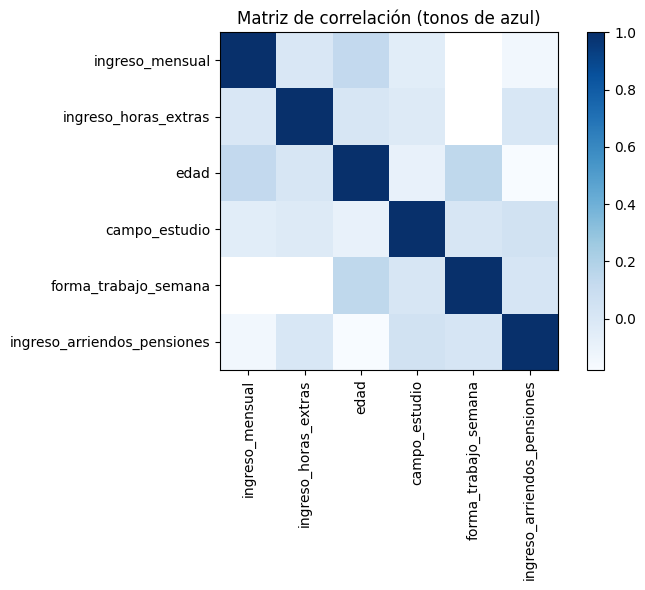

In [ ]:

corr = df_anual.select_dtypes(include=['int64','float64']).corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr, cmap='Blues', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title('Matriz de correlación (tonos de azul)')
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_anual['ingreso_mensual'].quantile(0.25)
Q3 = df_anual['ingreso_mensual'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQRs
upper = Q3 + 1.5 * IQR

outliers = df_anual[
    (df_anual['ingreso_mensual'] < lower) |
    (df_anual['ingreso_mensual'] > upper)
]
print(f"Número de outliers por IQR: {outliers.shape[0]}")


Número de outliers por IQR: 22677


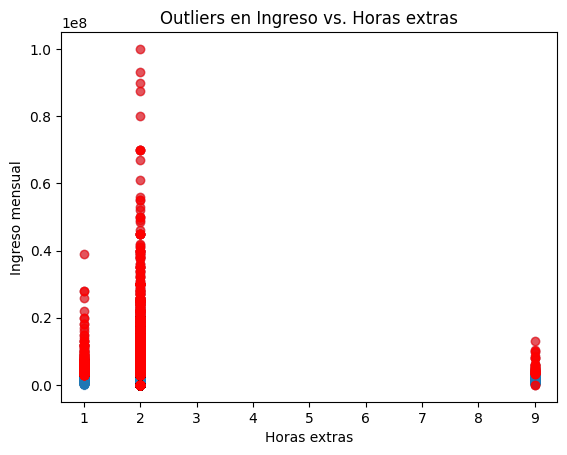

In [ ]:
plt.scatter(df_anual['ingreso_horas_extras'], df_anual['ingreso_mensual'], alpha=0.3)
plt.scatter(outliers['ingreso_horas_extras'], outliers['ingreso_mensual'], color='red', alpha=0.6)
plt.xlabel('Horas extras')
plt.ylabel('Ingreso mensual')
plt.title('Outliers en Ingreso vs. Horas extras')
plt.show()